In [1]:
%pip install git+https://github.com/jkirkby3/pymle.git

  Cloning https://github.com/jkirkby3/pymle.git to c:\users\mirom\appdata\local\temp\pip-req-build-wfnwnjxr
  Resolved https://github.com/jkirkby3/pymle.git to commit 412f74f5201782686f13ed2c60acd07b740c42e8
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/jkirkby3/pymle.git 'C:\Users\Mirom\AppData\Local\Temp\pip-req-build-wfnwnjxr'

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np, scipy.stats as st
from typing import Literal, Optional, List, Dict

from scipy.stats import norm
from tqdm import tqdm
from pymle.models import CIR, CKLS, OrnsteinUhlenbeck
from pymle.sim.Simulator1D import Simulator1D
from pymle.core.TransitionDensity import ExactDensity, KesslerDensity, OzakiDensity, EulerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE

In [3]:
from pymle.core.Model import Model1D
from pymle.core.TransitionDensity import TransitionDensity
from typing import Union

In [4]:
class CustomEulerDensity(TransitionDensity):
    def __init__(self, model: Model1D):
        """
        Class which represents the Euler approximation transition density for a model
        :param model: the SDE model, referenced during calls to the transition density
        """
        super().__init__(model=model)

    def __call__(
        self,
        x0: Union[float, np.ndarray],
        xt: Union[float, np.ndarray],
        t0: Union[float, np.ndarray],
        dt: float,
    ) -> Union[float, np.ndarray]:
        """
        The transition density obtained via Euler expansion
        :param x0: float or array, the current value
        :param xt: float or array, the value to transition to  (must be same dimension as x0)
        :param t0: float, the time of at which to evalate the coefficients. Irrelevant For time inhomogenous models
        :param dt: float, the time step between x0 and xt
        :return: probability (same dimension as x0 and xt)
        """
        # sig2t = (self._model.diffusion(x0, t0) ** 2) * 2 * dt
        # mut = x0 + self._model.drift(x0, t0) * dt
        # return np.exp(-(xt - mut) ** 2 / sig2t) / np.sqrt(np.pi * sig2t)

        mut = x0 + self._model.drift(x0, t0) * dt
        sig2t = (self._model.diffusion(x0, t0) ** 2) * dt

        return -1 / 2 * np.log(2 * np.pi * sig2t) - (xt - mut) ** 2 / (2 * sig2t)

In [5]:
class CustomOrnsteinUhlenbeck(Model1D):
    """
    Model for OU (ornstein-uhlenbeck):
    Parameters: [kappa, mu, sigma]

    dX(t) = mu(X,t)*dt + sigma(X,t)*dW_t

    where:
        mu(X,t)    = kappa * (mu - X)
        sigma(X,t) = sigma * X
    """

    def __init__(self):
        super().__init__(has_exact_density=True)

    def drift(self, x: Union[float, np.ndarray], t: float) -> Union[float, np.ndarray]:
        return self._params[0] * (self._params[1] - x)

    def diffusion(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        # return self._params[2] * (x > -10000)
        return self._params[2]

    def exact_density(self, x0: float, xt: float, t0: float, dt: float) -> float:
        kappa, theta, sigma = self._params
        mu = theta + (x0 - theta) * np.exp(-kappa * dt)
        # mu = X0*np.exp(-kappa*t) + theta*(1 - np.exp(-kappa*t))
        var = (1 - np.exp(-2 * kappa * dt)) * (sigma * sigma / (2 * kappa))
        return norm.pdf(xt, loc=mu, scale=np.sqrt(var))

    def AitSahalia_density(self, x0: float, xt: float, t0: float, dt: float) -> float:
        kappa, alpha, eta = self._params
        m = 1
        x = xt

        output = (
            (-m / 2) * np.log(2 * np.pi * dt)
            - np.log(eta)
            - ((x - x0) ** 2 / (2 * eta**2)) / dt
            + ((-(x**2 / 2) + x0**2 / 2 + x * alpha - x0 * alpha) * kappa) / eta**2
            - (
                (1 / (6 * eta**2))
                * (
                    kappa
                    * (
                        -3 * eta**2
                        + (
                            x**2
                            + x0**2
                            + x * (x0 - 3 * alpha)
                            - 3 * x0 * alpha
                            + 3 * alpha**2
                        )
                        * kappa
                    )
                )
            )
            * dt
            - (1 / 2) * (kappa**2 / 6) * dt**2
            + (1 / 6)
            * (
                (
                    4 * x**2
                    + 7 * x * x0
                    + 4 * x0**2
                    - 15 * x * alpha
                    - 15 * x0 * alpha
                    + 15 * alpha**2
                )
                * kappa**4
            )
            / (60 * eta**2)
            * dt**3
        )
        return np.exp(output)

    # =======================
    # (Optional) Overrides for numerical derivatives to improve performance
    # =======================

    def drift_t(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        return 0.0
    
    def drift_x(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        return -self._params[0]

    def diffusion_x(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        return 0.0

    def diffusion_xx(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        return 0.0


In [6]:
from scipy.special import ive

class CustomCIR(Model1D):
    """
    Model for CIR (cox-ingersol-ross)
    Parameters:  [kappa, mu, sigma]

    dX(t) = mu(X,t)*dt + sigma(X,t)*dW_t

    where:
        mu(X,t)    = kappa * (mu - X)
        sigma(X,t) = sigma * sqrt(X)         (sigma>0)

    """

    def __init__(self):
        super().__init__(has_exact_density=True)

    def drift(self, x: Union[float, np.ndarray], t: float) -> Union[float, np.ndarray]:
        return self._params[0] * (self._params[1] - x)

    def diffusion(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        return self._params[2] * np.sqrt(x)

    def exact_density(self, x0: float, xt: float, t0: float, dt: float) -> float:
        kappa, mu, sigma = self._params
        theta1 = kappa * mu
        theta2 = kappa
        theta3 = sigma

        et = np.exp(-theta2 * dt)
        c = 2 * theta2 / (theta3**2 * (1 - et))
        u = c * x0 * et
        v = c * xt
        q = 2 * theta1 / theta3**2 - 1

        z = 2 * np.sqrt(u * v)  # Note: we apply exponentail scaling trick
        p = c * np.exp(-(u + v) + np.abs(z)) * (v / u) ** (q / 2)

        z = 2 * np.sqrt(u * v)
        p *= ive(q, z)
        return p

    def AitSahalia_density(self, x0: float, xt: float, t0: float, dt: float) -> float:
        x = xt

        dell = dt

        kappa, mu, sigma = self._params

        am1 = 0
        a0 = kappa * mu
        a1 = -kappa
        a2 = 0

        b0 = 0
        b1 = 0
        b2 = sigma**2
        b3 = 1

        sx = np.sqrt(b0 + b1 * x + b2 * x**b3)

        cm1 = (
            -(
                (
                    (x - x0) ** 4
                    * (
                        15 * b1**2 * x0**2
                        - 2 * b1 * b2 * b3 * (-19 + 4 * b3) * x0 ** (1 + b3)
                        + b2
                        * b3
                        * x0**b3
                        * (-8 * b0 * (-1 + b3) + b2 * (8 + 7 * b3) * x0**b3)
                    )
                )
                / (96 * x0**2 * (b0 + b1 * x0 + b2 * x0**b3) ** 3)
            )
            + ((x - x0) ** 3 * (6 * b1 + 6 * b2 * b3 * x0 ** (-1 + b3)))
            / (24 * (b0 + b1 * x0 + b2 * x0**b3) ** 2)
            - (x - x0) ** 2 / (2 * (b0 + b1 * x0 + b2 * x0**b3))
        )

        c0 = (
            (x - x0)
            * (
                4 * am1
                + 4 * a0 * x0
                - b1 * x0
                + 4 * a1 * x0**2
                + 4 * a2 * x0**3
                - b2 * b3 * x0**b3
            )
        ) / (4 * x0 * (b0 + b1 * x0 + b2 * x0**b3)) + (
            1 / (8 * x0**2 * (b0 + b1 * x0 + b2 * x0**b3) ** 2)
        ) * (
            (x - x0) ** 2
            * (
                -4 * am1 * b0
                - 8 * am1 * b1 * x0
                + 4 * a1 * b0 * x0**2
                - 4 * a0 * b1 * x0**2
                + b1**2 * x0**2
                + 8 * a2 * b0 * x0**3
                + 4 * a2 * b1 * x0**4
                - 4 * am1 * b2 * x0**b3
                - 4 * am1 * b2 * b3 * x0**b3
                + b0 * b2 * b3 * x0**b3
                - b0 * b2 * b3**2 * x0**b3
                + b2**2 * b3 * x0 ** (2 * b3)
                - 4 * a0 * b2 * b3 * x0 ** (1 + b3)
                + 3 * b1 * b2 * b3 * x0 ** (1 + b3)
                - b1 * b2 * b3**2 * x0 ** (1 + b3)
                + 4 * a1 * b2 * x0 ** (2 + b3)
                - 4 * a1 * b2 * b3 * x0 ** (2 + b3)
                + 8 * a2 * b2 * x0 ** (3 + b3)
                - 4 * a2 * b2 * b3 * x0 ** (3 + b3)
            )
        )
        c1 = (1 / 8) * (
            -4 * (a1 - am1 / x0**2 + 2 * a2 * x0)
            - (b1 + b2 * b3 * x0 ** (-1 + b3)) ** 2 / (4 * (b0 + b1 * x0 + b2 * x0**b3))
            + (
                4
                * (b1 + b2 * b3 * x0 ** (-1 + b3))
                * (a0 + am1 / x0 + x0 * (a1 + a2 * x0))
            )
            / (b0 + b1 * x0 + b2 * x0**b3)
            - (4 * (a0 + am1 / x0 + x0 * (a1 + a2 * x0)) ** 2)
            / (b0 + b1 * x0 + b2 * x0**b3)
            + (
                (-(b1**2)) * x0**2
                + 2 * b1 * b2 * (-2 + b3) * b3 * x0 ** (1 + b3)
                + b2 * b3 * x0**b3 * (2 * b0 * (-1 + b3) + b2 * (-2 + b3) * x0**b3)
            )
            / (2 * x0**2 * (b0 + b1 * x0 + b2 * x0**b3))
        )

        output = (
            -(1 / 2) * np.log(2 * np.pi * dell)
            - np.log(sx)
            + cm1 / dell
            + c0
            + c1 * dell
        )

        return np.exp(output)

    def _set_is_positive(self, params: np.ndarray) -> bool:
        """CIR is always non-negative"""
        return True

    # =======================
    # (Optional) Overrides for numerical derivatives to improve performance
    # =======================

    def drift_t(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        return 0.0

    def drift_x(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        return -self._params[0]

    def drift_xx(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        return 0.0

    def diffusion_x(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        """Calculate first spatial derivative of diffusion term, dsigma/dx"""
        return self._params[2] / np.sqrt(x) / 2.

    def diffusion_xx(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        """Calculate second spatial derivative of diffusion term, d^2sigma/dx^2"""
        return -self._params[2] / (np.sqrt(x) ** 3.) / 4.

In [7]:
# Define auxiliary function to find minimal value
def argmin(iterable):
    return min(enumerate(iterable), key=lambda x: x[1])[0]

Task 1. Constant Maturity Interest Rates. Fit models (CEV, CIR, OU, CKLS) to a sample of historical interest rates over the period Jan 1, 1962 to till now. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using MLE approach.

The estimated parameters display in a table for each method. Calculate the AIC and select the best model. Compare your results with paper by Kirkby et. al (https://arxiv.org/abs/2108.12649) where the period from Jan 1, 1962 to April 8, 2021 (14,801 daily observations).

Dataset: Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10),
https://fred.stlouisfed.org/series/DGS10  

In [8]:
# Read data and preprocessing it
df_IR = pd.read_csv('DGS10.csv')
df_IR = df_IR[df_IR['DGS10'] != '.']

# Make valid numerical sample
sample = df_IR['DGS10'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

df_IR['DGS10'] = np.float64(df_IR.DGS10)
df_IR['DATE'] = pd.to_datetime(df_IR.DATE)

Task. Download the DGS10 dataset directlly from https://fred.stlouisfed.org/series/DGS10 .

Hint.

Use  
`from pymle.data.loader import load_10yr_CMrate`

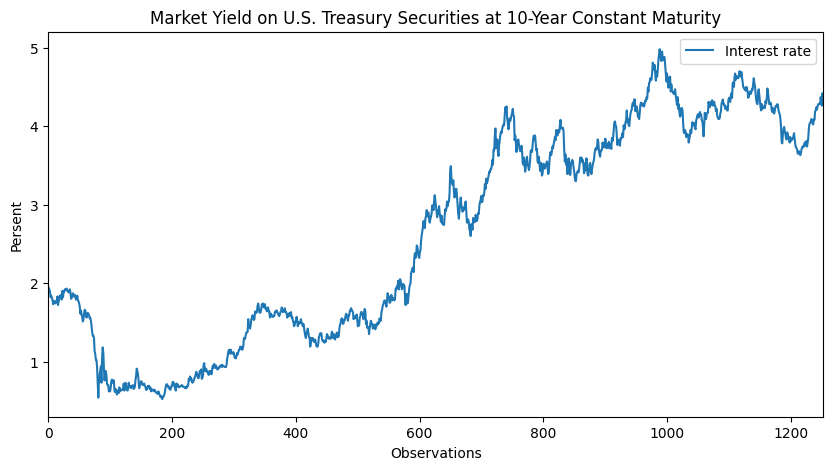

In [9]:
# Plot
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(np.linspace(0, len(sample), len(sample)),sample, label='Interest rate')
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.xlim(0, len(sample))
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

Task. Change the X marks to dates.

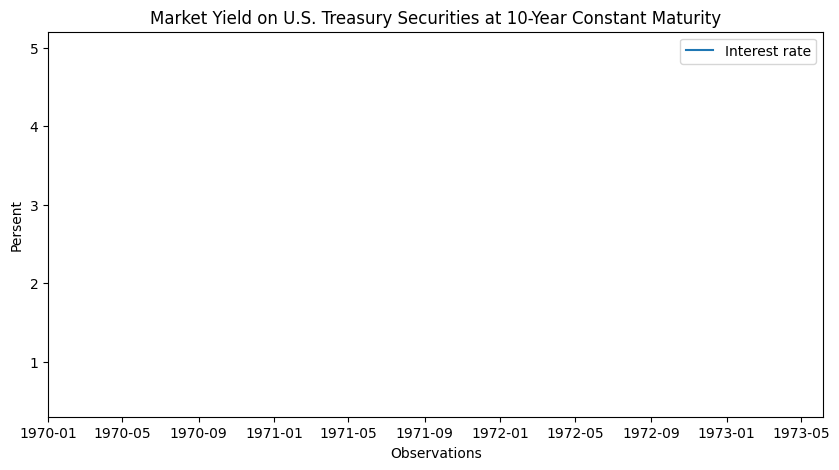

In [10]:
# Plot
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(df_IR.DATE, df_IR.DGS10, label='Interest rate')
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.xlim(0, len(df_IR.DGS10))
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

In [11]:
# Import models for fitting:
from pymle.models import BrownianMotion, CEV, CIR,\
                         CKLS, GeometricBM, IGBM, \
                         OrnsteinUhlenbeck

In [12]:
def fit_Kessler(model_name: Literal['BM', 'CEV', 'CIR', 'GBM', 'IGBM', 'OU', 'CKLS']):

    models = {'BM': BrownianMotion(),
              'CEV': CEV(),
              'CIR': CustomCIR(),
              'GBM':  GeometricBM(),
              'IGBM': IGBM(),
              'OU': CustomOrnsteinUhlenbeck(),
              'CKLS': CKLS()
              }
    
    if model_name not in list(models.keys()):
        raise ValueError(f'the model {model_name} does not exists\nchoose on from: {list(models.keys())}')

    # Create parametrization templates:
    param_bounds = {'BM': [(0.01, 10), (0.01, 2)],                         # Brownian Motion
                    'CEV': [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                    'CIR': [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    'GBM': [(0.01, 10), (0.01, 2)],                         # GBM
                    'IGBM': [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                    'OU': [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    'CKLS': [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
                    }

    param_guess  = {'BM': [0.01, 0.2],                                     # Brownian Motion
                    'CEV': [0.01, 0.01, 0.01, 0.2],                         # CEV
                    'CIR': [0.01, 0.01, 0.2],                               # CIR
                    'GBM': [0.01, 0.2],                                     # GBM
                    'IGBM': [0.01, 0.01, 0.2],                               # IGBM
                    'OU': [0.01, 0.01, 0.2],                               # OU
                    'CKLS': [0.01, 0.01, 0.01, 0.2]                          # CKLS
                    }
    
    # Set parameters for estimators:
    dt = 1. / 252

    # Estimate max likelyhood, using KesslerDensity
    kessler_est   = AnalyticalMLE(sample, param_bounds[model_name], dt, density=KesslerDensity(models[model_name])).estimate_params(param_guess[model_name]).aic
    kessler_params   = AnalyticalMLE(sample, param_bounds[model_name], dt, density=KesslerDensity(models[model_name])).estimate_params(param_guess[model_name]).params

    return kessler_est, kessler_params

In [13]:
# a) fit using Kessler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CustomCIR(), GeometricBM(), \
         IGBM(), CustomOrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252

# Estimate max likelyhood, using KesslerDensity
kessler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
kessler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.71867852545
`xtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 81, CG iterations: 52, optimality: 2.43e-04, constraint violation: 0.00e+00, execution time:  0.1 s.
Final Params: [0.4814598  0.99615003]
Final Likelihood: 1688.3914757526484
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873


c:\USERS\MIROM\DESKTOP\SSP\VENV\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 90, function evaluations: 445, CG iterations: 286, optimality: 2.21e+00, constraint violation: 0.00e+00, execution time: 0.35 s.
Final Params: [0.02640104 0.3064226  0.81465626 0.23205999]
Final Likelihood: 1713.917428502547
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2708.303332599745
`xtol` termination condition is satisfied.
Number of iterations: 96, function evaluations: 384, CG iterations: 202, optimality: 9.82e-05, constraint violation: 0.00e+00, execution time: 0.23 s.
Final Params: [0.16571724 5.52025962 0.68269806]
Final Likelihood: 1670.8076450206026
Initial Params: [0.01, 0.2]
Initial Likelihood: -943.8115685429168
`xtol` termination condition is satisfied.
Number of iterations: 34, function evaluations: 78, CG iterations: 43, optimality: 5.15e+00, constraint violation: 0.00e+00, execution time: 0.051 s.
Final Params: [0.32266321 0.59154681]
Final Likelihood: 1355.301856867824
Initial Params: [0.01, 

In [14]:
best_ind = argmin(kessler_est)
print("AIC values for Kessler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     kessler_est[0], model_name[0], kessler_params[0],\
     kessler_est[1], model_name[1], kessler_params[1],\
     kessler_est[2], model_name[2], kessler_params[2],\
     kessler_est[3], model_name[3], kessler_params[3],\
     kessler_est[4], model_name[4], kessler_params[4],\
     kessler_est[5], model_name[5], kessler_params[5],\
     kessler_est[6], model_name[6], kessler_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], kessler_params[best_ind]))

AIC values for Kessler estimation:
       -3372.783 - BrownianMotion model with params [0.4814598  0.99615003],
       -3419.835 - CEV model with params [0.02640104 0.3064226  0.81465626 0.23205999],
       -3335.615 - CIR model with params [0.16571724 5.52025962 0.68269806],
       -2706.604 - GeometricBM model with params [0.32266321 0.59154681],
       -2713.093 - IGBM model with params [0.7442021  2.53513878 0.59042787],
       -3370.958 - OrnsteinUhlenbeck model with params [0.13882061 6.09494042 0.9960843 ],
       -3421.412 - CKLS model with params [0.30992646 0.0513145  0.81560271 0.22976698],
       
The best model is CKLS     with param [0.30992646 0.0513145  0.81560271 0.22976698]


In [15]:
def fit_Shoji_Ozaki(model_name: Literal['BM', 'CEV', 'CIR', 'GBM', 'IGBM', 'OU', 'CKLS']):

    models = {'BM': BrownianMotion(),
              'CEV': CEV(),
              'CIR': CIR(),
              'GBM':  GeometricBM(),
              'IGBM': IGBM(),
              'OU': CustomOrnsteinUhlenbeck(),
              'CKLS': CKLS()
              }
    
    if model_name not in list(models.keys()):
        raise ValueError(f'the model {model_name} does not exists\nchoose on from: {list(models.keys())}')

    # Create parametrization templates:
    param_bounds = {'BM': [(0.01, 10), (0.01, 2)],                         # Brownian Motion
                    'CEV': [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                    'CIR': [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    'GBM': [(0.01, 10), (0.01, 2)],                         # GBM
                    'IGBM': [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                    'OU': [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    'CKLS': [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
                    }

    param_guess  = {'BM': [0.01, 0.2],                                     # Brownian Motion
                    'CEV': [0.01, 0.01, 0.01, 0.2],                         # CEV
                    'CIR': [0.01, 0.01, 0.2],                               # CIR
                    'GBM': [0.01, 0.2],                                     # GBM
                    'IGBM': [0.01, 0.01, 0.2],                               # IGBM
                    'OU': [0.01, 0.01, 0.2],                               # OU
                    'CKLS': [0.01, 0.01, 0.01, 0.2]                          # CKLS
                    }

    # Set parameters for estimators:
    dt = 1. / 252
    K = 1

    # Estimate max likelyhood, using Shoji-Ozaki
    shoji_ozaki_est = AnalyticalMLE(sample, param_bounds[model_name], dt, density=ShojiOzakiDensity(models[model_name])).estimate_params(param_guess[model_name]).aic
    shoji_ozaki_params = AnalyticalMLE(sample, param_bounds[model_name], dt, density=ShojiOzakiDensity(models[model_name])).estimate_params(param_guess[model_name]).params

    return shoji_ozaki_est, shoji_ozaki_params

In [16]:
# b) fit using Shoji-Ozaki method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
shoji_ozaki_est      = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
shoji_ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524912
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 72, CG iterations: 42, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.079 s.
Final Params: [0.4814409  0.99614996]
Final Likelihood: 1688.3914757537532
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.58998907219
`xtol` termination condition is satisfied.
Number of iterations: 115, function evaluations: 625, CG iterations: 344, optimality: 7.03e-04, constraint violation: 0.00e+00, execution time: 0.41 s.
Final Params: [0.06996685 9.81718124 0.81780759 0.22558579]
Final Likelihood: 1714.846275286819
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.3378924874087
`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 396, CG iterations: 233, optimality: 1.79e-01, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.31011762 

In [17]:
best_ind = argmin(shoji_ozaki_est)
print("AIC values for Shoji-Ozaki estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     shoji_ozaki_est[0], model_name[0], shoji_ozaki_params[0],\
     shoji_ozaki_est[1], model_name[1], shoji_ozaki_params[1],\
     shoji_ozaki_est[2], model_name[2], shoji_ozaki_params[2],\
     shoji_ozaki_est[3], model_name[3], shoji_ozaki_params[3],\
     shoji_ozaki_est[4], model_name[4], shoji_ozaki_params[4],\
     shoji_ozaki_est[5], model_name[5], shoji_ozaki_params[5],\
     shoji_ozaki_est[6], model_name[6], shoji_ozaki_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], shoji_ozaki_params[best_ind]))

AIC values for Shoji-Ozaki estimation:
       -3372.783 - BrownianMotion model with params [0.4814409  0.99614996],
       -3421.693 - CEV model with params [0.06996685 9.81718124 0.81780759 0.22558579],
       -3334.729 - CIR model with params [0.31011762 3.34738068 0.68419431],
       -2708.849 - GeometricBM model with params [0.32631368 0.59422328],
       -2711.256 - IGBM model with params [0.42076929 3.17959528 0.59405479],
       -3370.889 - OrnsteinUhlenbeck model with params [0.20844406 4.61366262 0.99651862],
       -3421.583 - CKLS model with params [0.49570307 0.01000847 0.81770082 0.22560421],
       
The best model is CEV     with param [0.06996685 9.81718124 0.81780759 0.22558579]


In [18]:
def fit_Euler(model_name: Literal['BM', 'CEV', 'CIR', 'GBM', 'IGBM', 'OU', 'CKLS']):

    models = {'BM': BrownianMotion(),
              'CEV': CEV(),
              'CIR': CustomCIR(),
              'GBM':  GeometricBM(),
              'IGBM': IGBM(),
              'OU': CustomOrnsteinUhlenbeck(),
              'CKLS': CKLS()
              }
    
    if model_name not in list(models.keys()):
        raise ValueError(f'the model {model_name} does not exists\nchoose on from: {list(models.keys())}')
    
    # Create parametrization templates:
    param_bounds = {'BM': [(0.01, 10), (0.01, 2)],                         # Brownian Motion
                    'CEV': [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                    'CIR': [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    'GBM': [(0.01, 10), (0.01, 2)],                         # GBM
                    'IGBM': [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                    'OU': [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    'CKLS': [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
                    }

    param_guess  = {'BM': [0.01, 0.2],                                     # Brownian Motion
                    'CEV': [0.01, 0.01, 0.01, 0.2],                         # CEV
                    'CIR': [0.01, 0.01, 0.2],                               # CIR
                    'GBM': [0.01, 0.2],                                     # GBM
                    'IGBM': [0.01, 0.01, 0.2],                               # IGBM
                    'OU': [0.01, 0.01, 0.2],                               # OU
                    'CKLS': [0.01, 0.01, 0.01, 0.2]                          # CKLS
                }

    # Set parameters for estimators:
    dt = 1. / 252
    K = 1

    # Estimate max likelyhood, using Shoji-Ozaki
    euler_est = AnalyticalMLE(sample, param_bounds[model_name], dt, density=CustomEulerDensity(models[model_name])).estimate_params(param_guess[model_name]).aic
    eu_params = AnalyticalMLE(sample, param_bounds[model_name], dt, density=CustomEulerDensity(models[model_name])).estimate_params(param_guess[model_name]).params
    # eu_params = AnalyticalMLE(sample, param_bounds[model_name], dt, density=ShojiOzakiDensity(models[model_name])).estimate_params(param_guess[model_name]).params

    return euler_est, eu_params

In [19]:
# c) fit using Euler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), CustomOrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]


"""
def EulerDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        xs = x0 + bxt(x0, t0, params) * (t - t0)
        sigma2 = sigmaxt(x0, t0, params)**2 * (t - t0)

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)
"""

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=CustomEulerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
eu_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=CustomEulerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -44467.56783526564
`xtol` termination condition is satisfied.
Number of iterations: 40, function evaluations: 129, CG iterations: 62, optimality: 7.49e-06, constraint violation: 0.00e+00, execution time: 0.081 s.
Final Params: [0.3597476  1.16914471]
Final Likelihood: -3288.350628941595
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79890.93201417371
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1380, CG iterations: 561, optimality: 1.30e-02, constraint violation: 0.00e+00, execution time:  0.7 s.
Final Params: [0.01000112 0.3178627  1.81836921 0.07097628]
Final Likelihood: -578.2772656256557
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -33796.17924514772
`xtol` termination condition is satisfied.
Number of iterations: 53, function evaluations: 220, CG iterations: 88, optimality: 1.78e-05, constraint violation: 0.00e+00, execution time: 0.13 s.
Final Params:

In [20]:
best_ind = argmin(euler_est)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est[0], model_name[0], eu_params[0],\
     euler_est[1], model_name[1], eu_params[1],\
     euler_est[2], model_name[2], eu_params[2],\
     euler_est[3], model_name[3], eu_params[3],\
     euler_est[4], model_name[4], eu_params[4],\
     euler_est[5], model_name[5], eu_params[5],\
     euler_est[6], model_name[6], eu_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], eu_params[best_ind]))

AIC values for Euler estimation:
       6580.701 - BrownianMotion model with params [0.3597476  1.16914471],
       1164.555 - CEV model with params [0.01000112 0.3178627  1.81836921 0.07097628],
       4299.040 - CIR model with params [0.16440128 0.01001703 0.80606684],
       3603.994 - GeometricBM model with params [0.35499847 0.82134693],
       3112.318 - IGBM model with params [0.70979496 0.29175026 0.88592556],
       2227.844 - OrnsteinUhlenbeck model with params [0.80724252 1.17929863 1.53601381],
       2211.329 - CKLS model with params [3.2069937  0.06808502 1.20110806 0.30127034],
       
The best model is CEV     with param [0.01000112 0.3178627  1.81836921 0.07097628]


In [21]:
print("For the best model {}\n \
    params are:\n \
    {},\n \
    {},\n \
    {}".format(
    model_name[best_ind],\
    kessler_params[best_ind],\
    shoji_ozaki_params[best_ind],\
    eu_params[best_ind]))

For the best model CEV
     params are:
     [0.02640104 0.3064226  0.81465626 0.23205999],
     [0.06996685 9.81718124 0.81780759 0.22558579],
     [0.01000112 0.3178627  1.81836921 0.07097628]


In [22]:
model_id = 1

print("For the best model {}\n \
    params are:\n \
    {},\n \
    {},\n \
    {}".format(
    model_name[model_id],\
    kessler_params[model_id],\
    shoji_ozaki_params[model_id],\
    eu_params[model_id]))

For the best model CEV
     params are:
     [0.02640104 0.3064226  0.81465626 0.23205999],
     [0.06996685 9.81718124 0.81780759 0.22558579],
     [0.01000112 0.3178627  1.81836921 0.07097628]


In [23]:
# Was stated in the lab task (?)

shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

Task: Rewrite code and pass estimated parameters programmatically.

In [24]:
# your code
def get_parameters(model_name: Literal["BM", "CEV", "CIR", "GBM", "IGBM", "OU", "CKLS"],
                    method: Literal["shoji_ozaki", 'kessler', "euler"]):
    
    models = ["BM", "CEV", "CIR", "GBM", "IGBM", "OU", "CKLS"]
    methods = ["shoji_ozaki", 'kessler', "euler"]
        
    if model_name not in models:
        raise ValueError(f'model {model_name} does not exist, choose one from {models}')
    
    if method not in methods:
        raise ValueError(f'method {method} does not exist, choose one from {methods}')
    
    if method == 'shoji_ozaki':
        estimation, params = fit_Shoji_Ozaki(model_name)
        return params
    elif method == 'euler':
        estimation, params = fit_Euler(model_name)
        return params
    elif method == 'kessler':
        estimation, params = fit_Kessler(model_name)
        return params

In [25]:
# Generate a CEV process with estimated parameters
# Define auxiliary functions:
def Wiener_proc(N, T):
    W = np.zeros(N)
    delta = T / N
    sqrt_delta = np.sqrt(delta)
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

#  CEV process:
def CEV_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS

processes = {'CEV': CEV_pr}

In [26]:
sample = df_IR.DGS10.values

In [27]:
cW = [sample[i] - sample[i-1] for i in range(1, len(sample))]

In [28]:
MODEL = 'CEV'

shoji_ozaki_p = get_parameters(model_name=MODEL, method='shoji_ozaki')
kessler_p = get_parameters(model_name=MODEL, method='kessler')
euler_p = get_parameters(model_name=MODEL, method='euler')

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.58998907219
`xtol` termination condition is satisfied.
Number of iterations: 115, function evaluations: 625, CG iterations: 344, optimality: 7.03e-04, constraint violation: 0.00e+00, execution time: 0.37 s.
Final Params: [0.06996685 9.81718124 0.81780759 0.22558579]
Final Likelihood: 1714.846275286819
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.58998907219
`xtol` termination condition is satisfied.
Number of iterations: 115, function evaluations: 625, CG iterations: 344, optimality: 7.03e-04, constraint violation: 0.00e+00, execution time: 0.39 s.
Final Params: [0.06996685 9.81718124 0.81780759 0.22558579]
Final Likelihood: 1714.846275286819
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873
`xtol` termination condition is satisfied.
Number of iterations: 90, function evaluations: 445, CG iterations: 286, optimality: 2.21e+00, constraint violation: 0.00e+00, execution t

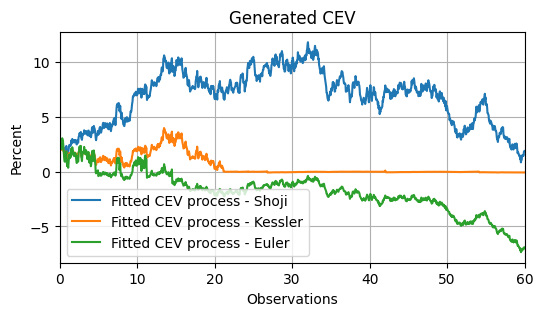

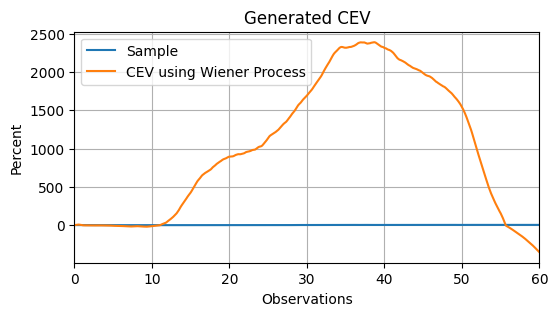

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]

# Set params that were fitted:
# kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
# kappa, mu, sigma, gamma = euler_p

time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)

cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

# Fix for np.nan_to_num in NumPy 2.x
def safe_nan_to_num(arr, copy=True):
    return np.nan_to_num(np.asarray(arr), copy=copy)

for i in range(1, N):
    dW = W[i] - W[i - 1]

    # Safe calculation for processes with power operation (avoid negative base with fractional exponent)
    def safe_process_calculation(S, kappa, mu, sigma, gamma, dt, dW):
        if S <= 0 and gamma < 1:
            S = max(S, 1e-8)  # Set to a small positive value to prevent NaN issues
        dS = kappa * (mu - S) * dt + sigma * (S ** gamma) * dW
        return dS

    # Update processes using the safe calculation
    cev_s[i] = safe_nan_to_num(cev_s[i - 1] + safe_process_calculation(cev_s[i - 1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW))
    cev_k[i] = safe_nan_to_num(cev_k[i - 1] + safe_process_calculation(cev_k[i - 1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW))
    cev_e[i] = safe_nan_to_num(cev_e[i - 1] + safe_process_calculation(cev_e[i - 1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW))
    ecev[i] = safe_nan_to_num(ecev[i - 1] + safe_process_calculation(ecev[i - 1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, W[i - 1]))

# Plotting the processes
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s, label=f"Fitted {MODEL} process - Shoji")
plt.plot(time_line, cev_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, cev_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Percent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

# Plotting the sample and ecev process
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label=f'{MODEL} using Wiener Process')
plt.title(f"Generated {MODEL}")
plt.ylabel('Percent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

Task. Generate a CKLS process with estimated parameters.

In [33]:
# your code
MODEL = 'CKLS'

# get params
shoji_ozaki_p = get_parameters(model_name=MODEL, method='shoji_ozaki')
kessler_p = get_parameters(model_name=MODEL, method='kessler')
euler_p = get_parameters(model_name=MODEL, method='euler')

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79286.4317422433
`gtol` termination condition is satisfied.
Number of iterations: 122, function evaluations: 590, CG iterations: 344, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.49570307 0.01000847 0.81770082 0.22560421]
Final Likelihood: 1714.791399490157
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79286.4317422433
`gtol` termination condition is satisfied.
Number of iterations: 122, function evaluations: 590, CG iterations: 344, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.49570307 0.01000847 0.81770082 0.22560421]
Final Likelihood: 1714.791399490157
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79286.5247501723
`xtol` termination condition is satisfied.
Number of iterations: 97, function evaluations: 495, CG iterations: 288, optimality: 2.75e+00, constraint violation: 0.00e+00, execution time

In [34]:
def CKLS_pr(dx, theta1, theta2, theta3, theta4, dt, dw):
    return (theta1 + theta2 * dx) * dt + theta3 * pow(dx, theta4) * dw

processes[MODEL] = CKLS_pr

C:\Users\Mirom\AppData\Local\Temp\ipykernel_29972\1826396453.py:2: RuntimeWarning: invalid value encountered in scalar power
  return (theta1 + theta2 * dx) * dt + theta3 * pow(dx, theta4) * dw


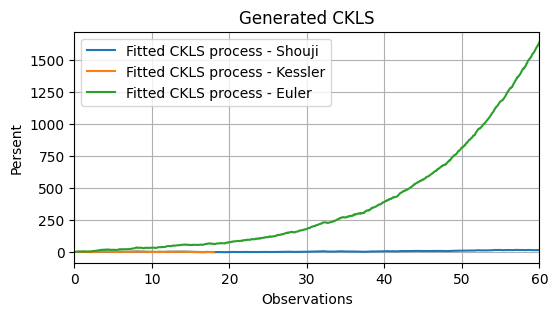

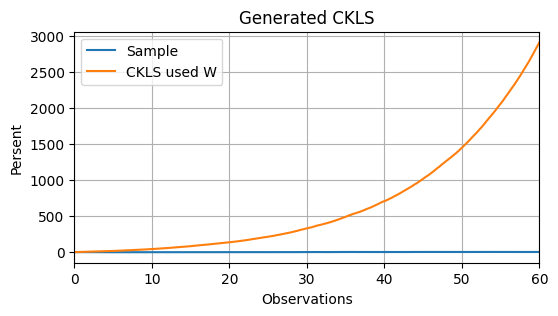

In [35]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + processes[MODEL](cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    cev_k[i] = cev_k[i-1] + processes[MODEL](cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    cev_e[i] = cev_e[i-1] + processes[MODEL](cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    ecev[i] = ecev[i-1] + processes[MODEL](ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, cev_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, cev_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [36]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est_aic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    euler_est_bic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    euler_params  = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    ozaki_est_aic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    ozaki_est_bic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    shoji_est_aic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    shoji_est_bic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    shoji_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    kessler_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    kessler_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    kessler_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    exact_est_aic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    exact_est_bic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    exact_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.055 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 117, function evaluations: 570, CG iterations: 312, optimality: 1.14e-05, constraint violation: 0.00e+00, execution time: 0.17 s.
Final Params: [0.09880466 7.45657585 0.8177117  0.22555164]
Final Likelihood: 1714.8509939717858
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.1287756483916
`xtol` termination condition is satisfied.
Number of iterations: 89, function evaluations: 336, CG iterations: 173, optimality: 7.83e-06, constraint violation: 0.00e+00, execution time:  0.1 s.
Final Params: [0.12312797 

c:\USERS\MIROM\DESKTOP\SSP\VENV\Lib\site-packages\pymle\core\TransitionDensity.py:114: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x


`xtol` termination condition is satisfied.
Number of iterations: 85, function evaluations: 390, CG iterations: 253, optimality: 1.74e-05, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [0.10361544 7.25293261 0.81657149 0.22649144]
Final Likelihood: 1714.8681218489023
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.336560225884
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 224, CG iterations: 118, optimality: 9.42e-05, constraint violation: 0.00e+00, execution time: 0.073 s.
Final Params: [0.20708512 4.94128693 0.68293537]
Final Likelihood: 1670.9609783882995
Initial Params: [0.01, 0.2]
Initial Likelihood: -946.8114936804857
`xtol` termination condition is satisfied.
Number of iterations: 44, function evaluations: 138, CG iterations: 68, optimality: 3.73e-06, constraint violation: 0.00e+00, execution time: 0.048 s.
Final Params: [0.33658369 0.59420799]
Final Likelihood: 1356.4251690787437
Initial Params: [0.

100%|██████████| 1/1 [00:11<00:00, 11.37s/it]

`xtol` termination condition is satisfied.
Number of iterations: 116, function evaluations: 468, CG iterations: 245, optimality: 2.02e-05, constraint violation: 0.00e+00, execution time: 0.13 s.
Final Params: [0.13680634 6.13425603 0.99608023]
Final Likelihood: 1688.479067249849
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79286.55610856632
`gtol` termination condition is satisfied.
Number of iterations: 51, function evaluations: 220, CG iterations: 134, optimality: 8.97e-07, constraint violation: 0.00e+00, execution time: 0.068 s.
Final Params: [0.4957242  0.01000117 0.81771706 0.22560419]
Final Likelihood: 1714.7914077054265


Task. Calculate the AIC and select the best model. Compare results with solution of Task 1.

In [37]:
models = ['BM', 'CEV', 'CIR', 'GBM', 'IGBM', 'OU', 'CKLS']

In [38]:
best_ind = argmin(euler_est_aic)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est_aic[0], models[0], euler_params[0],\
     euler_est_aic[1], models[1], euler_params[1],\
     euler_est_aic[2], models[2], euler_params[2],\
     euler_est_aic[3], models[3], euler_params[3],\
     euler_est_aic[4], models[4], euler_params[4],\
     euler_est_aic[5], models[5], euler_params[5],\
     euler_est_aic[6], models[6], euler_params[6]))

print("The best model is {} \
    with param {}".format(models[best_ind], euler_params[best_ind]))

AIC values for Euler estimation:
       -3372.783 - BM model with params [0.48143899 0.99614996],
       -3421.702 - CEV model with params [0.09880466 7.45657585 0.8177117  0.22555164],
       -3335.102 - CIR model with params [0.12312797 6.52508367 0.68367189],
       -2708.850 - GBM model with params [0.33680851 0.59460504],
       -2711.257 - IGBM model with params [0.436573   3.09444961 0.59355865],
       -3370.958 - OU model with params [0.13680634 6.13425603 0.99608023],
       -3421.583 - CKLS model with params [0.4957242  0.01000117 0.81771706 0.22560419],
       
The best model is CEV     with param [0.09880466 7.45657585 0.8177117  0.22555164]


In [39]:
# your code
best_ind = argmin(euler_est_bic)
print("BIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est_bic[0], models[0], euler_params[0],\
     euler_est_bic[1], models[1], euler_params[1],\
     euler_est_bic[2], models[2], euler_params[2],\
     euler_est_bic[3], models[3], euler_params[3],\
     euler_est_bic[4], models[4], euler_params[4],\
     euler_est_bic[5], models[5], euler_params[5],\
     euler_est_bic[6], models[6], euler_params[6]))

print("The best model is {} \
    with param {}".format(models[best_ind], euler_params[best_ind]))

BIC values for Euler estimation:
       -3362.520 - BM model with params [0.48143899 0.99614996],
       -3401.175 - CEV model with params [0.09880466 7.45657585 0.8177117  0.22555164],
       -3319.707 - CIR model with params [0.12312797 6.52508367 0.68367189],
       -2698.587 - GBM model with params [0.33680851 0.59460504],
       -2695.862 - IGBM model with params [0.436573   3.09444961 0.59355865],
       -3355.563 - OU model with params [0.13680634 6.13425603 0.99608023],
       -3401.056 - CKLS model with params [0.4957242  0.01000117 0.81771706 0.22560419],
       
The best model is CEV     with param [0.09880466 7.45657585 0.8177117  0.22555164]


As it was earlier CEV is the best model

In [40]:
# Implement multiprocessing approach for solving
import multiprocessing
def MLE_Estimator(i):
    # a) fit using Kessler method:

    # Choose several models:
    model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
             IGBM(), OrnsteinUhlenbeck(), CKLS()]

    # Create parametrization templates:
    param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    [(0.01, 10), (0.01, 2)],                         # GBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
                   ]

    param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                    [0.01, 0.01, 0.01, 0.2],                         # CEV
                    [0.01, 0.01, 0.2],                               # CIR
                    [0.01, 0.2],                                     # GBM
                    [0.01, 0.01, 0.2],                               # IGBM
                    [0.01, 0.01, 0.2],                               # OU
                    [0.01, 0.01, 0.01, 0.2]                          # CKLS
                   ]

    #pb = param_bounds[0]
    #pg = np.array([1., 0.5])
    #m = BrownianMotion()

    # Set parameters for estimators:
    dt = 1. / 252
    K = 1
    eu_params = []
    oz_params = []
    so_params = []
    ks_params = []
    ex_params = []

    #euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

    for k in tqdm(range(K)):
        seed = rnd.randint(1, 10000)
        euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        eu_params.append(euler_est)
        oz_params.append(ozaki_est)
        so_params.append(shoji_est)
        ks_params.append(kessler_est)
        ex_params.append(exact_est)
    return [eu_params,
            oz_params,
            so_params,
            ks_params,
            ex_params]

In [ ]:
# Run estimator with parallel calculating:
K = 100
i_range   = [i for i in range(100)]
pool_obj = multiprocessing.Pool()
answer = pool_obj.map(MLE_Estimator, i_range)

Task 2. USD/Euro Exchange Rates.

Fit a time series of USD/EUR exchange rates over the period Jan 1, 1999 to till now (daily observations)  by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates display in a table for each method. Calculate the AIC and BIC and select the best model. Compare your results with paper (Kirkby et.al., 2022), where period was from Jan 1, 1999 to May 21, 2021 (daily observations).

Dataset: U.S./Euro Foreign Exchange Rate [DEXUSEU], retrieved from FRED, Federal Reserve Bank of St. Louis;
https://fred.stlouisfed.org/series/DEXUSEU

In [ ]:
def CIR_pr(dx, theta1, theta2, theta3, theta4, dt, dw):
    return (theta1 - theta2 * dx) * dt + theta3 * dx ** 0.5 * dw

processes['CIR'] = CIR_pr

def OU_pr(dx, theta1, theta2, theta3, theta4, dt, dw):
    return (theta1 - theta2 * dx) * dt + theta3 * dw

processes['OU'] = OU_pr

In [ ]:
# your code
df_USEU = pd.read_csv('DEXUSEU.csv')

In [ ]:
df_USEU.head()

,DATE,DEXUSEU
0,1999-01-04,1.1812
1,1999-01-05,1.1760
2,1999-01-06,1.1636
3,1999-01-07,1.1672
4,1999-01-08,1.1554


In [ ]:
df_USEU.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6740 entries, 0 to 6739
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   DATE     6740 non-null   object
 1   DEXUSEU  6740 non-null   object
dtypes: object(2)
memory usage: 105.4+ KB


In [ ]:
df_USEU.describe()

,DATE,DEXUSEU
count,6740,6740
unique,6740,3788
top,1999-01-04,.
freq,1,259


In [ ]:
df_USEU = df_USEU[df_USEU['DEXUSEU'] != '.']

# Make valid numerical sample
sample = df_USEU['DEXUSEU'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

df_USEU['DEXUSEU'] = np.float64(df_USEU.DEXUSEU)
df_USEU['DATE'] = pd.to_datetime(df_USEU.DATE)

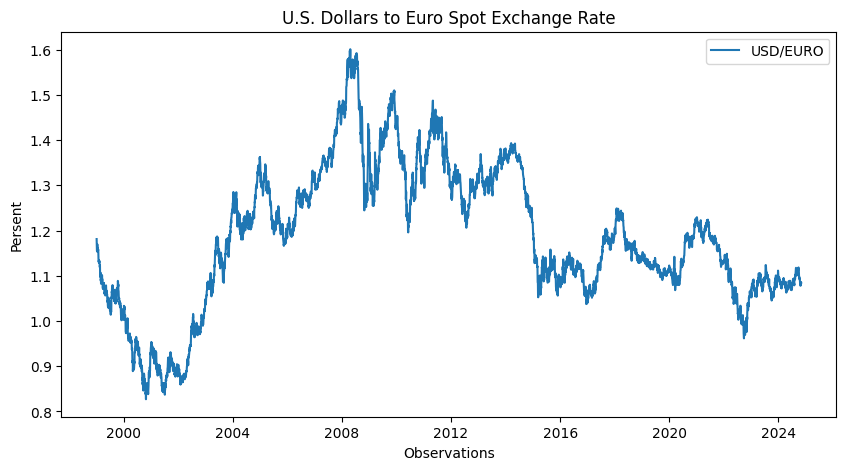

In [ ]:
# Plot

##### c датой не работает почему-то

figure, ax = plt.subplots(figsize=(10,5))
ax.plot(df_USEU['DATE'], df_USEU['DEXUSEU'], label='USD/EURO')
# plt.plot(df_USEU['DEXUSEU'], label='USD/EURO')
# df_USEU["DEXUSEU"].plot()
plt.title('U.S. Dollars to Euro Spot Exchange Rate')
# plt.xlim(0, len(df_USEU.DEXUSEU))
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

In [ ]:
MODEL = 'CEV'

euler_p = get_parameters(MODEL, 'euler')
kessler_p = get_parameters(MODEL, 'kessler')
shoji_ozaki_p = get_parameters(MODEL, 'shoji_ozaki')

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147678.57260201464
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 2.77e+03, constraint violation: 0.00e+00, execution time: 0.99 s.
Final Params: [0.2337731  0.23392371 0.6292321  0.35952845]
Final Likelihood: 14497.611511951462
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147678.57260201464
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 2.77e+03, constraint violation: 0.00e+00, execution time: 0.96 s.
Final Params: [0.2337731  0.23392371 0.6292321  0.35952845]
Final Likelihood: 14497.611511951462
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147678.62218543063
`xtol` termination condition is satisfied.
Number of iterations: 73, function evaluations: 310, CG iterations: 222, optimality: 2.57e+01, constraint

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_41374/2431532227.py:13: RuntimeWarning: invalid value encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW


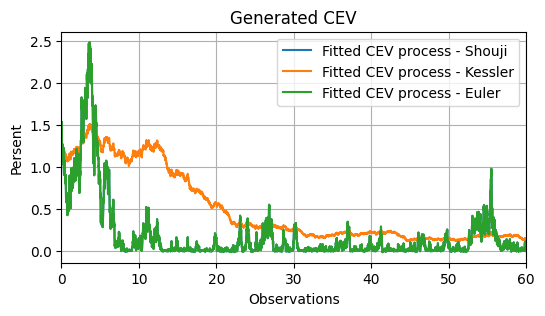

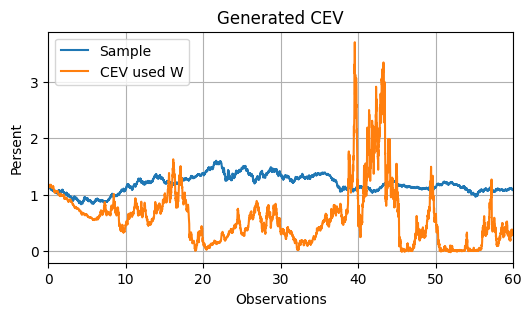

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = np.nan_to_num(cev_s[i-1] + processes[MODEL](cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW), cev_s[i-1])
    cev_k[i] = np.nan_to_num(cev_k[i-1] + processes[MODEL](cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW), cev_k[i-1])
    cev_e[i] = np.nan_to_num(cev_e[i-1] + processes[MODEL](cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW), cev_e[i-1])
    ecev[i] = np.nan_to_num(ecev[i-1] + processes[MODEL](ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1]), ecev[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, cev_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, cev_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [ ]:
MODEL = 'CKLS'

euler_p = get_parameters(MODEL, 'euler')
kessler_p = get_parameters(MODEL, 'kessler')
shoji_ozaki_p = get_parameters(MODEL, 'shoji_ozaki')

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147695.3740386047
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 2.76e+03, constraint violation: 0.00e+00, execution time: 0.97 s.
Final Params: [0.23379757 0.23374217 0.63008097 0.35973871]
Final Likelihood: 14482.667792289318
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147695.3740386047
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 2.76e+03, constraint violation: 0.00e+00, execution time:  1.0 s.
Final Params: [0.23379757 0.23374217 0.63008097 0.35973871]
Final Likelihood: 14482.667792289318
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147693.55015750762


/Users/hubievkasym/Desktop/Python Projects/SberProject/venv/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 153, function evaluations: 815, CG iterations: 406, optimality: 2.67e-01, constraint violation: 0.00e+00, execution time: 0.94 s.
Final Params: [0.01008382 0.01010165 0.09196957 1.03424613]
Final Likelihood: 23101.09677127396
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147693.55015750762
`xtol` termination condition is satisfied.
Number of iterations: 153, function evaluations: 815, CG iterations: 406, optimality: 2.67e-01, constraint violation: 0.00e+00, execution time:  0.9 s.
Final Params: [0.01008382 0.01010165 0.09196957 1.03424613]
Final Likelihood: 23101.09677127396
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147691.9530598798
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 2.76e+03, constraint violation: 0.00e+00, execution time:  1.2 s.
Final Params: [0.23378419 0.23361624 0.6300319  0.

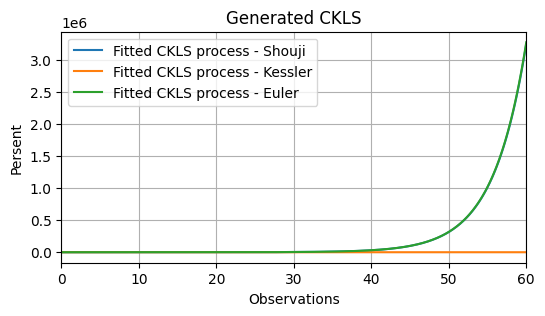

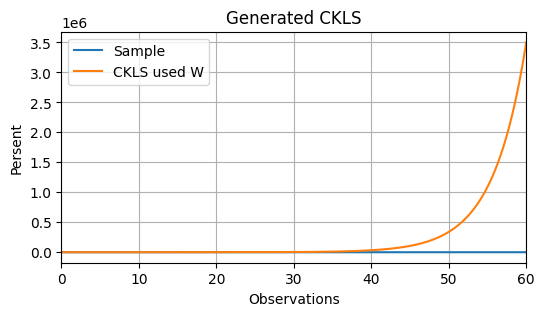

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ckls_s, ckls_k, ckls_e = np.zeros(N), np.zeros(N), np.zeros(N)
ckls_s[0], ckls_k[0], ckls_e[0] = S0, S0, S0
eckls = np.zeros(N)
eckls[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ckls_s[i] = ckls_s[i-1] + processes[MODEL](ckls_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    ckls_k[i] = ckls_k[i-1] + processes[MODEL](ckls_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    ckls_e[i] = ckls_e[i-1] + processes[MODEL](ckls_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    eckls[i] = eckls[i-1] + processes[MODEL](eckls[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, ckls_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, ckls_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, ckls_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eckls, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [ ]:
MODEL = 'OU'

euler_p = get_parameters(MODEL, 'euler')
kessler_p = get_parameters(MODEL, 'kessler')
shoji_ozaki_p = get_parameters(MODEL, 'shoji_ozaki')

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 21389.768266444138
`xtol` termination condition is satisfied.
Number of iterations: 89, function evaluations: 332, CG iterations: 159, optimality: 3.07e-06, constraint violation: 0.00e+00, execution time: 0.31 s.
Final Params: [0.24562364 1.17019588 0.11108683]
Final Likelihood: 22960.05951208082
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 21389.768266444138
`xtol` termination condition is satisfied.
Number of iterations: 89, function evaluations: 332, CG iterations: 159, optimality: 3.07e-06, constraint violation: 0.00e+00, execution time: 0.26 s.
Final Params: [0.24562364 1.17019588 0.11108683]
Final Likelihood: 22960.05951208082
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 21389.768265722487
`xtol` termination condition is satisfied.
Number of iterations: 90, function evaluations: 440, CG iterations: 153, optimality: 1.22e-04, constraint violation: 0.00e+00, execution time: 0.29 s.
Final Params: [0.01046995 0.0

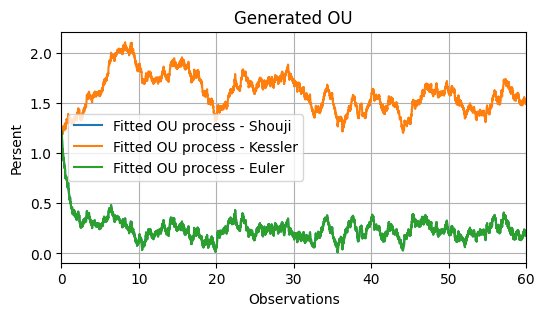

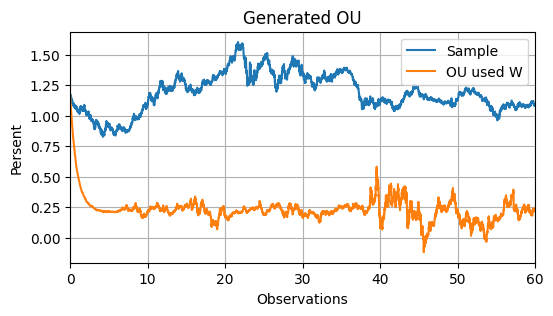

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma = kessler_p
gamma = 0.0
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ou_s, ou_k, ou_e = np.zeros(N), np.zeros(N), np.zeros(N)
ou_s[0], ou_k[0], ou_e[0] = S0, S0, S0
eou = np.zeros(N)
eou[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ou_s[i] = ou_s[i-1] + processes[MODEL](ou_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], gamma, dt, dW)
    ou_k[i] = ou_k[i-1] + processes[MODEL](ou_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], gamma, dt, dW)
    ou_e[i] = ou_e[i-1] + processes[MODEL](ou_e[i-1], euler_p[0], euler_p[1], euler_p[2], gamma, dt, dW)
    eou[i] = eou[i-1] + processes[MODEL](eou[i-1], euler_p[0], euler_p[1], euler_p[2], gamma, dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, ou_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, ou_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, ou_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eou, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [ ]:
MODEL = 'CIR'

euler_p = get_parameters(MODEL, 'euler')
kessler_p = get_parameters(MODEL, 'kessler')
shoji_ozaki_p = get_parameters(MODEL, 'shoji_ozaki')

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 21042.96300835637
`xtol` termination condition is satisfied.
Number of iterations: 73, function evaluations: 288, CG iterations: 139, optimality: 1.05e-04, constraint violation: 0.00e+00, execution time: 0.26 s.
Final Params: [0.23245766 1.16933169 0.10084736]
Final Likelihood: 23064.042054397767
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 21042.96300835637
`xtol` termination condition is satisfied.
Number of iterations: 73, function evaluations: 288, CG iterations: 139, optimality: 1.05e-04, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.23245766 1.16933169 0.10084736]
Final Likelihood: 23064.042054397767
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 21041.970763710175
`xtol` termination condition is satisfied.
Number of iterations: 148, function evaluations: 608, CG iterations: 313, optimality: 1.01e-02, constraint violation: 0.00e+00, execution time: 0.51 s.
Final Params: [0.23048387 1.

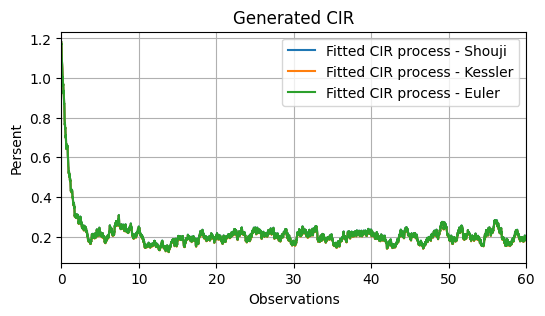

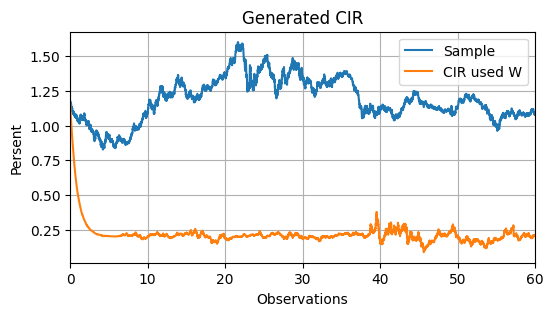

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma = kessler_p
gamma = 0.0
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cir_s, cir_k, cir_e = np.zeros(N), np.zeros(N), np.zeros(N)
cir_s[0], cir_k[0], cir_e[0] = S0, S0, S0
ecir = np.zeros(N)
ecir[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cir_s[i] = cir_s[i-1] + processes[MODEL](cir_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], gamma, dt, dW)
    cir_k[i] = cir_k[i-1] + processes[MODEL](cir_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], gamma, dt, dW)
    cir_e[i] = cir_e[i-1] + processes[MODEL](cir_e[i-1], euler_p[0], euler_p[1], euler_p[2], gamma, dt, dW)
    ecir[i] = ecir[i-1] + processes[MODEL](ecir[i-1], euler_p[0], euler_p[1], euler_p[2], gamma, dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cir_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, cir_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, cir_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecir, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [ ]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est_bic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    euler_est_aic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    euler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    ozaki_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    ozaki_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    ozaki_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    shoji_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    shoji_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    shoji_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    kessler_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    kessler_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    kessler_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    exact_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    exact_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    exact_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: 21389.69046908656
`gtol` termination condition is satisfied.
Number of iterations: 45, function evaluations: 126, CG iterations: 77, optimality: 3.31e-07, constraint violation: 0.00e+00, execution time: 0.18 s.
Final Params: [0.01000563 0.11111643]
Final Likelihood: 22958.333427230355
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147678.57260201464
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 2.77e+03, constraint violation: 0.00e+00, execution time: 0.99 s.
Final Params: [0.2337731  0.23392371 0.6292321  0.35952845]
Final Likelihood: 14497.611511951462
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 21042.96300835637
`xtol` termination condition is satisfied.
Number of iterations: 73, function evaluations: 288, CG iterations: 139, optimality: 1.05e-04, constraint violation: 0.00e+00, execution time: 0.28 s.
Final Params: 

/Users/hubievkasym/Desktop/Python Projects/SberProject/venv/lib/python3.9/site-packages/pymle/core/TransitionDensity.py:114: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time: 0.26 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147681.93768298533
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 2.77e+03, constraint violation: 0.00e+00, execution time:  1.1 s.
Final Params: [0.23386944 0.23390649 0.62926647 0.35953709]
Final Likelihood: 14499.594585386341
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 21043.05804556309
`xtol` termination condition is satisfied.
Number of iterations: 63, function evaluations: 248, CG iterations: 136, optimality: 3.94e-03, constraint violation: 0.00e+00, execution time: 0.25 s.
Final Params: [0.22759262 1.16896345 0.10084815]
Final Likelihood: 23063.980454580356
Initial Param

100%|██████████| 1/1 [00:48<00:00, 48.65s/it]

The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 2.76e+03, constraint violation: 0.00e+00, execution time: 0.93 s.
Final Params: [0.23379757 0.23374217 0.63008097 0.35973871]
Final Likelihood: 14482.667792289318


In [ ]:
# from Task1

best_ind = argmin(euler_est_aic)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est_aic[0], models[0], euler_params[0],\
     euler_est_aic[1], models[1], euler_params[1],\
     euler_est_aic[2], models[2], euler_params[2],\
     euler_est_aic[3], models[3], euler_params[3],\
     euler_est_aic[4], models[4], euler_params[4],\
     euler_est_aic[5], models[5], euler_params[5],\
     euler_est_aic[6], models[6], euler_params[6]))

print("The best model is {} \
    with param {}".format(models[best_ind], euler_params[best_ind]))

AIC values for Euler estimation:
       -45912.667 - BM model with params [0.01000563 0.11111643],
       -28987.223 - CEV model with params [0.2337731  0.23392371 0.6292321  0.35952845],
       -46122.084 - CIR model with params [0.23245766 1.16933169 0.10084736],
       -46198.347 - GBM model with params [0.01000596 0.09250109],
       -46199.418 - IGBM model with params [0.22379602 1.16951785 0.09247918],
       -45914.119 - OU model with params [0.24562364 1.17019588 0.11108683],
       -28957.336 - CKLS model with params [0.23379757 0.23374217 0.63008097 0.35973871],
       
The best model is IGBM     with param [0.22379602 1.16951785 0.09247918]


In [ ]:

best_ind = argmin(euler_est_bic)
print("BIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est_bic[0], models[0], euler_params[0],\
     euler_est_bic[1], models[1], euler_params[1],\
     euler_est_bic[2], models[2], euler_params[2],\
     euler_est_bic[3], models[3], euler_params[3],\
     euler_est_bic[4], models[4], euler_params[4],\
     euler_est_bic[5], models[5], euler_params[5],\
     euler_est_bic[6], models[6], euler_params[6]))

print("The best model is {} \
    with param {}".format(models[best_ind], euler_params[best_ind]))

BIC values for Euler estimation:
       -45899.114 - BM model with params [0.01000563 0.11111643],
       -28960.117 - CEV model with params [0.2337731  0.23392371 0.6292321  0.35952845],
       -46101.755 - CIR model with params [0.23245766 1.16933169 0.10084736],
       -46184.794 - GBM model with params [0.01000596 0.09250109],
       -46179.088 - IGBM model with params [0.22379602 1.16951785 0.09247918],
       -45893.790 - OU model with params [0.24562364 1.17019588 0.11108683],
       -28930.230 - CKLS model with params [0.23379757 0.23374217 0.63008097 0.35973871],
       
The best model is GBM     with param [0.01000596 0.09250109]


This time in terms of AIC the best model is IGBM, but in terms of BIC - GBM

Task 3. U.S. Interest Rates.

Fit a time series of IRates over the period  from 06/1964
to 12/1989 (monthly data) by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates
display in Table for each method. Calculate the AIC and BIC, and select the best model. Compare your results with paper by [Brouste et. al.](https://www.semanticscholar.org/paper/The-YUIMA-Project%3A-A-Computational-Framework-for-of-Brouste-Fukasawa/e9a4696779261dbeca55f316943307d7da5d3d1b) (page 43):

$$dX_t = (2.08 - 0.26 X_t)dt + 0.13 X^{1.44}_t dW_t.$$

Dataset: In order to obtain the data one can open browser, type the address https://rdrr.io/snippets/ and run the code in R language:



```
library(Ecdat)
data(Irates)
rates = Irates[, "r1"]; rates
plot(rates)
```



In [ ]:
paper_params = [2.08, 0.26, 0.13, 1.44]

In [ ]:
# your code
data = {'1946': [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 0.325],
        '1947':	[0.322, 0.326, 0.318, 0.302, 0.288, 0.328, 0.378, 0.528, 0.742, 0.732, 0.814, 0.904],
        '1948':	[0.959, 0.968, 0.978, 0.984, 0.987, 0.975, 0.992, 1.063, 1.082, 1.084, 1.101, 1.110],
        '1949':	[1.126, 1.139, 1.114, 1.123, 1.092, 1.016, 0.960, 0.982, 1.010, 0.985, 1.011, 1.035],
        '1950':	[1.072, 1.100, 1.084, 1.112, 1.136, 1.129, 1.158, 1.246, 1.291, 1.184, 1.307, 1.250],
        '1951':	[1.209, 1.210, 1.439, 1.329, 1.344, 1.382, 1.491, 1.538, 1.596, 1.258, 1.388, 1.696],
        '1952':	[1.332, 1.342, 1.374, 1.579, 1.642, 1.747, 1.802, 1.712, 1.459, 1.589, 1.781, 1.941],
        '1953':	[1.819, 2.019, 1.987, 2.062, 1.935, 1.606, 1.936, 1.790, 1.220, 0.975, 1.439, 1.248],
        '1954':	[0.958, 0.887, 0.985, 0.673, 0.603, 0.620, 0.679, 1.107, 0.903, 0.845, 0.929, 0.949],
        '1955':	[1.097, 1.139, 1.328, 1.496, 1.152, 1.271, 1.667, 1.948, 2.145, 2.052, 2.111, 2.424],
        '1956':	[2.278, 1.969, 2.198, 2.628, 2.374, 2.333, 2.082, 2.396, 2.700, 2.560, 2.806, 3.077],
        '1957':	[3.064, 2.938, 2.886, 3.021, 3.210, 3.083, 3.056, 3.072, 3.228, 3.361, 2.635, 2.728],
        '1958':	[1.456, 1.137, 0.990, 1.155, 0.249, 0.747, 0.704, 1.872, 1.949, 1.822, 1.904, 2.419],
        '1959':	[2.467, 2.379, 2.567, 2.739, 2.747, 2.774, 2.399, 3.477, 3.638, 3.169, 3.531, 4.079],
        '1960':	[3.538, 3.807, 2.683, 2.970, 2.596, 1.655, 1.831, 1.972, 2.340, 1.606, 1.789, 2.026],
        '1961':	[2.039, 2.482, 2.192, 1.933, 2.239, 2.078, 1.744, 2.047, 1.992, 1.957, 2.278, 2.483],
        '1962': [2.485, 2.485, 2.632, 2.694, 2.455, 2.928, 2.685, 2.661, 2.686, 2.533, 2.671, 2.941],
        '1963':	[2.928, 2.842, 2.204, 2.853, 2.950, 2.975, 3.053, 3.264, 3.437, 3.364, 3.274, 3.511],
        '1964':	[3.424, 3.528, 3.513, 3.320, 3.289, 3.456, 3.317, 3.398, 3.526, 3.451, 3.631, 3.561],
        '1965':	[3.854, 3.866, 3.822, 3.885, 3.863, 3.787, 3.812, 3.807, 3.949, 3.917, 3.925, 4.440],
        '1966':	[4.521, 4.497, 4.403, 4.631, 4.495, 4.495, 4.576, 4.792, 5.198, 4.848, 4.624, 4.699],
        '1967':	[4.537, 4.372, 4.014, 3.543, 3.345, 3.748, 3.788, 3.928, 4.248, 4.185, 4.275, 4.426],
        '1968':	[4.739, 4.788, 4.941, 5.335, 5.568, 5.289, 5.102, 5.049, 5.197, 5.336, 5.071, 6.138],
        '1969':	[5.948, 5.892, 5.638, 6.111, 5.971, 6.256, 6.547, 7.047, 7.031, 6.694, 6.892, 7.280],
        '1970':	[7.622, 6.683, 6.425, 6.523, 6.564, 6.119, 5.920, 6.238, 5.557, 5.455, 4.754, 4.572],
        '1971':	[4.113, 3.250, 3.462, 3.807, 4.203, 4.950, 5.206, 4.456, 4.473, 4.057, 4.064, 3.330],
        '1972':	[3.024, 3.250, 3.420, 3.285, 3.503, 3.675, 3.555, 4.346, 4.482, 4.540, 4.793, 4.927],
        '1973':	[5.437, 5.592, 6.083, 6.013, 6.531, 7.454, 8.289, 8.636, 7.126, 7.147, 7.488, 7.292],
        '1974':	[7.518, 7.578, 8.513, 8.727, 7.664, 7.655, 7.553, 9.205, 6.056, 7.117, 7.452, 6.770],
        '1975':	[5.533, 4.977, 5.266, 5.149, 4.940, 5.667, 6.003, 5.980, 6.310, 5.360, 5.125, 5.056],
        '1976':	[4.525, 4.672, 4.778, 4.696, 5.244, 5.296, 5.102, 4.978, 5.068, 4.745, 4.412, 4.263],
        '1977':	[4.566, 4.523, 4.507, 4.442, 4.901, 4.956, 5.248, 5.381, 5.743, 6.111, 5.672, 5.822],
        '1978':	[6.070, 6.226, 6.564, 6.026, 6.442, 6.606, 6.554, 7.875, 7.997, 8.655, 8.989, 8.628],
        '1979':	[9.507, 9.627, 9.589, 9.584, 9.778, 8.977, 9.136, 10.107, 10.218, 11.728, 11.230, 10.274],
        '1980':	[11.871, 13.919, 15.071, 10.389, 7.847, 6.665, 7.835, 9.200, 11.204, 11.657, 14.394, 12.901],
        '1981':	[14.717, 14.197, 13.034, 14.114, 16.210, 14.413, 14.980, 15.639, 13.679, 12.972, 10.237, 9.710],
        '1982':	[12.141, 11.980, 13.963, 12.316, 11.616, 11.742, 9.147, 7.513, 6.937, 7.722, 7.873, 8.071],
        '1983':	[8.066, 7.909, 8.558, 8.099, 8.559, 8.568, 8.955, 9.008, 8.775, 8.491, 8.576, 8.633],
        '1984':	[8.940, 8.863, 9.504, 9.488, 9.558, 9.386, 10.029, 10.743, 10.442, 8.570, 8.000, 7.229],
        '1985':	[7.725, 7.671, 8.037, 7.516, 6.996, 6.719, 7.056, 7.243, 7.109, 7.165, 6.592, 6.237],
        '1986':	[6.805, 6.887, 6.579, 5.981, 6.234, 6.006, 5.499, 4.859, 5.202, 5.033, 5.241, 4.998],
        '1987':	[5.510, 5.489, 5.201, 4.984, 5.597, 5.397, 5.546, 5.805, 6.484, 4.364, 3.800, 3.880],
        '1988':	[4.930, 5.267, 5.730, 5.768, 6.083, 6.128, 6.524, 7.544, 7.073, 6.957, 7.084, 7.196],
        '1989':	[8.066, 8.075, 9.043, 8.630, 8.519, 8.254, 7.934, 7.501, 7.588, 7.842, 7.938, 6.651],
        '1990':	[7.627, 7.740, 8.083, 7.666, 7.652, 7.613, 7.596, 7.537, 6.959, 6.709, 6.659, 5.867],
        '1991':	[5.953, 5.677, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan] 									       	     
        }

In [ ]:
data.keys()

dict_keys(['1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991'])

In [ ]:
monthes = {0: '01', 1: '02', 2: '03', 3: '04', 4: '05', 5: '06', 6: '07', 7: '08', 8: '09', 9: '10', 10: '11', 11: '12'}

dates, values = [], []

for date in list(data.keys()):
    items = data[date]
    for i in range(len(items)):
        dates.append(f"{date}-{monthes[i]}-01")
        values.append(items[i])

dates = pd.to_datetime(dates)

print(len(dates), len(values))

552 552


In [ ]:
df = pd.DataFrame({'DARE': dates, 'IR': values})
df.to_csv('IntrestRate.csv')

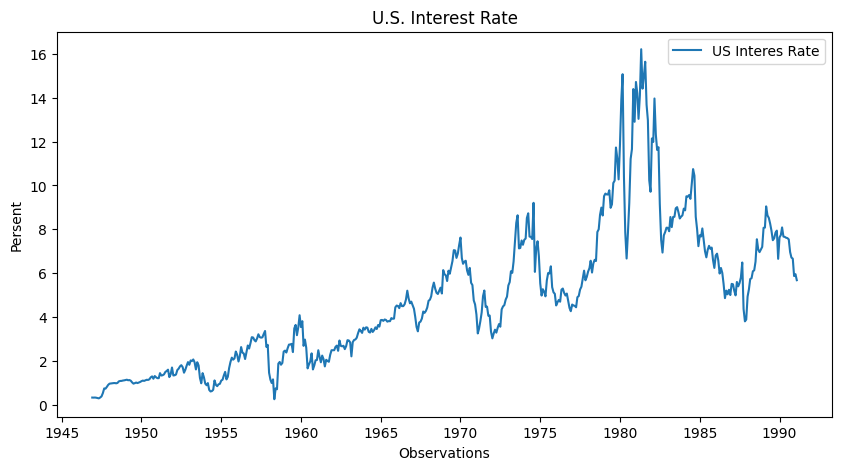

In [ ]:
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(dates, values, label='US Interes Rate')
plt.title('U.S. Interest Rate')
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

In [ ]:
sample = df.IR.dropna().values

In [ ]:
# your code
MODEL = 'CEV'

# get params
shoji_ozaki_p = get_parameters(model_name=MODEL, method='shoji_ozaki')
kessler_p = get_parameters(model_name=MODEL, method='kessler')
euler_p = get_parameters(model_name=MODEL, method='euler')

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35672.53579376933
`xtol` termination condition is satisfied.
Number of iterations: 53, function evaluations: 265, CG iterations: 165, optimality: 8.92e+00, constraint violation: 0.00e+00, execution time: 0.15 s.
Final Params: [0.86078321 0.93464319 3.40404825 0.57355689]
Final Likelihood: -330.5341204864193
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35672.53579376933
`xtol` termination condition is satisfied.
Number of iterations: 53, function evaluations: 265, CG iterations: 165, optimality: 8.92e+00, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [0.86078321 0.93464319 3.40404825 0.57355689]
Final Likelihood: -330.5341204864193
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35672.5169125899
`xtol` termination condition is satisfied.
Number of iterations: 45, function evaluations: 240, CG iterations: 109, optimality: 9.56e+01, constraint violation: 0.00e+00, execution ti

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_41374/2431532227.py:13: RuntimeWarning: invalid value encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW


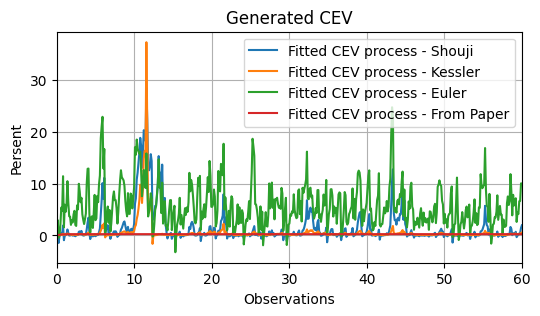

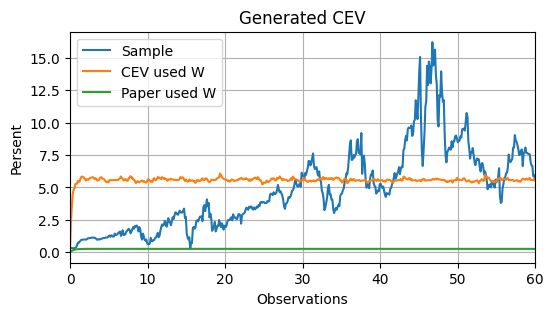

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_paper = np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = np.nan_to_num(cev_s[i-1] + processes[MODEL](cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW), cev_s[i-1])
    cev_k[i] = np.nan_to_num(cev_k[i-1] + processes[MODEL](cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW), cev_k[i-1])
    cev_e[i] = np.nan_to_num(cev_e[i-1] + processes[MODEL](cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW), cev_e[i-1])
    ecev[i] = np.nan_to_num(ecev[i-1] + processes[MODEL](ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1]), ecev[i-1])
    cev_paper[i] = np.nan_to_num(cev_paper[i-1] + processes[MODEL](cev_paper[i-1], paper_params[0], paper_params[1], paper_params[2], paper_params[3], dt, cW[i-1]), cev_paper[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s , label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, cev_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, cev_e, label=f"Fitted {MODEL} process - Euler")
plt.plot(time_line, cev_paper, label=f"Fitted {MODEL} process - From Paper")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label=f'{MODEL} used W')
plt.plot(time_line, cev_paper, label=f'Paper used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [ ]:
# your code
MODEL = 'CKLS'

# get params
shoji_ozaki_p = get_parameters(model_name=MODEL, method='shoji_ozaki')
kessler_p = get_parameters(model_name=MODEL, method='kessler')
euler_p = get_parameters(model_name=MODEL, method='euler')

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35662.20942956937
`xtol` termination condition is satisfied.
Number of iterations: 71, function evaluations: 340, CG iterations: 220, optimality: 9.92e+00, constraint violation: 0.00e+00, execution time:  0.2 s.
Final Params: [1.0142667  1.03945486 3.36497828 0.57764926]
Final Likelihood: -329.68398855815053
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35662.20942956937
`xtol` termination condition is satisfied.
Number of iterations: 71, function evaluations: 340, CG iterations: 220, optimality: 9.92e+00, constraint violation: 0.00e+00, execution time: 0.24 s.
Final Params: [1.0142667  1.03945486 3.36497828 0.57764926]
Final Likelihood: -329.68398855815053
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35662.22063715826
`xtol` termination condition is satisfied.
Number of iterations: 46, function evaluations: 240, CG iterations: 109, optimality: 1.46e+02, constraint violation: 0.00e+00, execution

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_41374/1826396453.py:2: RuntimeWarning: invalid value encountered in scalar power
  return (theta1 + theta2 * dx) * dt + theta3 * pow(dx, theta4) * dw


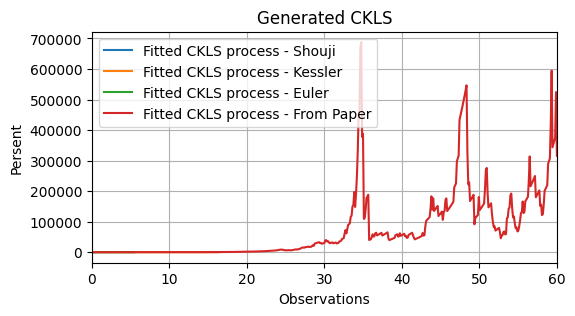

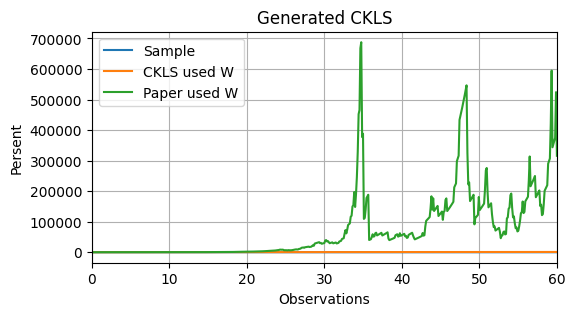

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ckls_s, ckls_k, ckls_e = np.zeros(N), np.zeros(N), np.zeros(N)
ckls_paper = np.zeros(N)
ckls_s[0], ckls_k[0], ckls_e[0] = S0, S0, S0
eckls = np.zeros(N)
eckls[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ckls_s[i] = ckls_s[i-1] + processes[MODEL](ckls_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    ckls_k[i] = ckls_k[i-1] + processes[MODEL](ckls_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    ckls_e[i] = ckls_e[i-1] + processes[MODEL](ckls_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    eckls[i] = eckls[i-1] + processes[MODEL](eckls[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])
    ckls_paper[i] = ckls_paper[i-1] + processes[MODEL](ckls_paper[i-1], paper_params[0], paper_params[1], paper_params[2], paper_params[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, ckls_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, ckls_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, ckls_e, label=f"Fitted {MODEL} process - Euler")
plt.plot(time_line, ckls_paper, label=f"Fitted {MODEL} process - From Paper")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eckls, label=f'{MODEL} used W')
plt.plot(time_line, ckls_paper, label=f'Paper used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [ ]:
# your code
MODEL = 'OU'

# get params
shoji_ozaki_p = get_parameters(model_name=MODEL, method='shoji_ozaki')
kessler_p = get_parameters(model_name=MODEL, method='kessler')
euler_p = get_parameters(model_name=MODEL, method='euler')

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -24678.622128076182
`xtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 148, CG iterations: 49, optimality: 1.74e-02, constraint violation: 0.00e+00, execution time: 0.12 s.
Final Params: [0.01007962 0.83459657 1.99999977]
Final Likelihood: -3420.6304542203807
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -24678.622128076182
`xtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 148, CG iterations: 49, optimality: 1.74e-02, constraint violation: 0.00e+00, execution time: 0.091 s.
Final Params: [0.01007962 0.83459657 1.99999977]
Final Likelihood: -3420.6304542203807
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -24678.443880142735
`xtol` termination condition is satisfied.
Number of iterations: 63, function evaluations: 276, CG iterations: 88, optimality: 2.21e-02, constraint violation: 0.00e+00, execution time: 0.19 s.
Final Params: [1.7971527

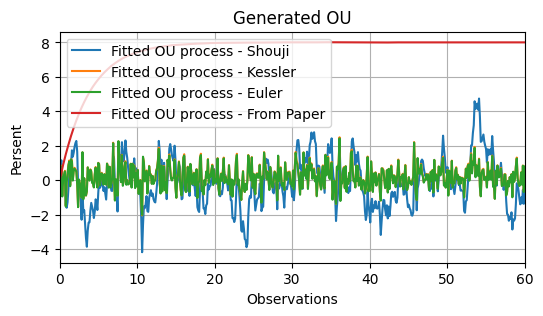

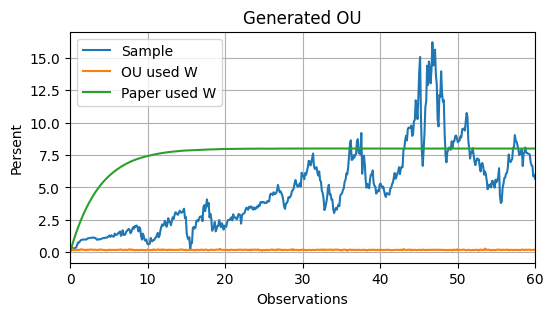

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma = kessler_p
gamma = 0.0
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ou_s, ou_k, ou_e = np.zeros(N), np.zeros(N), np.zeros(N)
ou_paper = np.zeros(N)
ou_s[0], ou_k[0], ou_e[0] = S0, S0, S0
eou = np.zeros(N)
eou[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ou_s[i] = ou_s[i-1] + processes[MODEL](ou_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], gamma, dt, dW)
    ou_k[i] = ou_k[i-1] + processes[MODEL](ou_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], gamma, dt, dW)
    ou_e[i] = ou_e[i-1] + processes[MODEL](ou_e[i-1], euler_p[0], euler_p[1], euler_p[2], gamma, dt, dW)
    eou[i] = eou[i-1] + processes[MODEL](eou[i-1], euler_p[0], euler_p[1], euler_p[2], gamma, dt, cW[i-1])
    ou_paper[i] = ou_paper[i-1] + processes[MODEL](ou_paper[i-1], paper_params[0], paper_params[1], 
                                                   paper_params[2], paper_params[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, ou_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, ou_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, ou_e, label=f"Fitted {MODEL} process - Euler")
plt.plot(time_line, ou_paper, label=f"Fitted {MODEL} process - From Paper")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eou, label=f'{MODEL} used W')
plt.plot(time_line, ou_paper, label=f'Paper used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [ ]:
# your code
MODEL = 'CIR'

# get params
shoji_ozaki_p = get_parameters(model_name=MODEL, method='shoji_ozaki')
kessler_p = get_parameters(model_name=MODEL, method='kessler')
euler_p = get_parameters(model_name=MODEL, method='euler')

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18254.742102094562
`xtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 152, CG iterations: 65, optimality: 4.64e+00, constraint violation: 0.00e+00, execution time: 0.085 s.
Final Params: [0.75232468 0.76253019 1.99984124]
Final Likelihood: -674.2944587903598
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18254.742102094562
`xtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 152, CG iterations: 65, optimality: 4.64e+00, constraint violation: 0.00e+00, execution time: 0.074 s.
Final Params: [0.75232468 0.76253019 1.99984124]
Final Likelihood: -674.2944587903598
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18252.900715605694
`xtol` termination condition is satisfied.
Number of iterations: 54, function evaluations: 244, CG iterations: 113, optimality: 5.36e-04, constraint violation: 0.00e+00, execution time: 0.16 s.
Final Params: [3.6893420

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_41374/3007526269.py:2: RuntimeWarning: invalid value encountered in scalar power
  return (theta1 - theta2 * dx) * dt + theta3 * dx ** 0.5 * dw


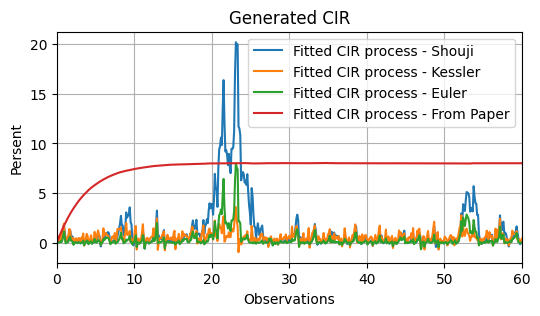

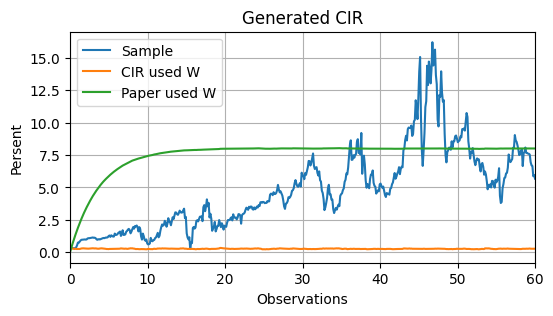

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma = kessler_p
gamma = 0.0
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cir_s, cir_k, cir_e = np.zeros(N), np.zeros(N), np.zeros(N)
cir_paper = np.zeros(N)
cir_s[0], cir_k[0], cir_e[0] = S0, S0, S0
ecir = np.zeros(N)
ecir[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cir_s[i] = np.nan_to_num(cir_s[i-1] + processes[MODEL](cir_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], gamma, dt, dW), cir_s[i-1])
    cir_k[i] = np.nan_to_num(cir_k[i-1] + processes[MODEL](cir_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], gamma, dt, dW), cir_k[i-1])
    cir_e[i] = np.nan_to_num(cir_e[i-1] + processes[MODEL](cir_e[i-1], euler_p[0], euler_p[1], euler_p[2], gamma, dt, dW), cir_e[i-1])
    ecir[i] = np.nan_to_num(ecir[i-1] + processes[MODEL](ecir[i-1], euler_p[0], euler_p[1], euler_p[2], gamma, dt, cW[i-1]), ecir[i-1])
    cir_paper[i] = np.nan_to_num(cir_paper[i-1] + processes[MODEL](cir_paper[i-1], paper_params[0], paper_params[1], 
                                                                   paper_params[2], paper_params[3], dt, cW[i-1]), 
                                                                   cir_paper[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cir_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, cir_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, cir_e, label=f"Fitted {MODEL} process - Euler")
plt.plot(time_line, cir_paper, label=f"Fitted {MODEL} process - From Paper")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecir, label=f'{MODEL} used W')
plt.plot(time_line, cir_paper, label=f'Paper used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [ ]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est_bic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    euler_est_aic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    euler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    ozaki_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    ozaki_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    ozaki_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    shoji_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    shoji_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    shoji_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    kessler_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    kessler_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    kessler_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    exact_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    exact_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    exact_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -24674.766899037822
`gtol` termination condition is satisfied.
Number of iterations: 24, function evaluations: 54, CG iterations: 29, optimality: 5.11e-07, constraint violation: 0.00e+00, execution time: 0.071 s.
Final Params: [8.29614119 2.        ]
Final Likelihood: -3404.7452329280623
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35672.516707370334
`xtol` termination condition is satisfied.
Number of iterations: 86, function evaluations: 410, CG iterations: 239, optimality: 3.11e-06, constraint violation: 0.00e+00, execution time: 0.24 s.
Final Params: [3.34153876 5.56943774 3.27136434 0.59261942]
Final Likelihood: -324.0244868999782
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18254.50404503303
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1000, CG iterations: 265, optimality: 6.08e-01, constraint violation: 0.00e+00, execution time: 0.74 s.
Final Para

100%|██████████| 1/1 [00:19<00:00, 19.57s/it]

`xtol` termination condition is satisfied.
Number of iterations: 78, function evaluations: 420, CG iterations: 206, optimality: 1.90e-06, constraint violation: 0.00e+00, execution time: 0.22 s.
Final Params: [9.99998768 0.01000121 3.29758718 0.58943767]
Final Likelihood: -326.0593806423507


In [ ]:
# from Task1

best_ind = argmin(euler_est_aic)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est_aic[0], models[0], euler_params[0],\
     euler_est_aic[1], models[1], euler_params[1],\
     euler_est_aic[2], models[2], euler_params[2],\
     euler_est_aic[3], models[3], euler_params[3],\
     euler_est_aic[4], models[4], euler_params[4],\
     euler_est_aic[5], models[5], euler_params[5],\
     euler_est_aic[6], models[6], euler_params[6]))

print("The best model is {} \
    with param {}".format(models[best_ind], euler_params[best_ind]))

AIC values for Euler estimation:
       6813.490 - BM model with params [8.29614119 2.        ],
       656.049 - CEV model with params [3.34153876 5.56943774 3.27136434 0.59261942],
       1348.751 - CIR model with params [0.38448269 1.48202372 1.99984903],
       879.491 - GBM model with params [2.26884929 1.82643756],
       873.715 - IGBM model with params [0.77612466 9.98133093 1.81303729],
       6812.866 - OU model with params [1.58970816 8.81790509 2.        ],
       660.119 - CKLS model with params [9.99998768 0.01000121 3.29758718 0.58943767],
       
The best model is CEV     with param [3.34153876 5.56943774 3.27136434 0.59261942]


In [ ]:
best_ind = argmin(euler_est_bic)
print("BIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est_bic[0], models[0], euler_params[0],\
     euler_est_bic[1], models[1], euler_params[1],\
     euler_est_bic[2], models[2], euler_params[2],\
     euler_est_bic[3], models[3], euler_params[3],\
     euler_est_bic[4], models[4], euler_params[4],\
     euler_est_bic[5], models[5], euler_params[5],\
     euler_est_bic[6], models[6], euler_params[6]))

print("The best model is {} \
    with param {}".format(models[best_ind], euler_params[best_ind]))

print(f"\nParameters from the paper: {paper_params}\n")

print(f"While {models[-1]} estimated parameters: {euler_params[-1]}")

BIC values for Euler estimation:
       6822.036 - BM model with params [8.29614119 2.        ],
       673.140 - CEV model with params [3.34153876 5.56943774 3.27136434 0.59261942],
       1361.569 - CIR model with params [0.38448269 1.48202372 1.99984903],
       888.037 - GBM model with params [2.26884929 1.82643756],
       886.533 - IGBM model with params [0.77612466 9.98133093 1.81303729],
       6825.684 - OU model with params [1.58970816 8.81790509 2.        ],
       677.210 - CKLS model with params [9.99998768 0.01000121 3.29758718 0.58943767],
       
The best model is CEV     with param [3.34153876 5.56943774 3.27136434 0.59261942]

Parameters from the paper: [2.08, 0.26, 0.13, 1.44]

While CKLS estimated parameters: [9.99998768 0.01000121 3.29758718 0.58943767]


Estimated parameters differ from the ones offered by the paper authors, even for the most fitted model CKLS

Task 4.

Take a dual-listed security (for instance, Apple, Google, Amazon), which trade simultaneously on two exchanges. Fit a time series of spread over the 5 years period (day data) by CEV, CIR, OU, CKLS models.

For example, one can use the paper by [Bertram, 2009](https://https://www.sciencedirect.com/science/article/pii/S0378437109002829)
where a spread constructed on the dual-listed security, ANZ Bank (ANZ). Calculate the AIC and BIC, and select the best model.

Hint. Use refs for selection a dual-listed security. Calculate the AIC and BIC, and select the best model.

https://live.euronext.com/en/product/equities/US0378331005-MTAH

https://stockanalysis.com/list/indian-stocks-us/

In [ ]:
# your code
import yfinance as yf

In [ ]:
goog = yf.Ticker("GOOG")
goog_hist = goog.history(period='max', interval='1d')

In [ ]:
googl = yf.Ticker('GOOGL')
googl_hist = googl.history(period='max', interval='1d')

In [ ]:
goog_hist.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [ ]:
spread = (goog_hist.Close - googl_hist.Close).abs()

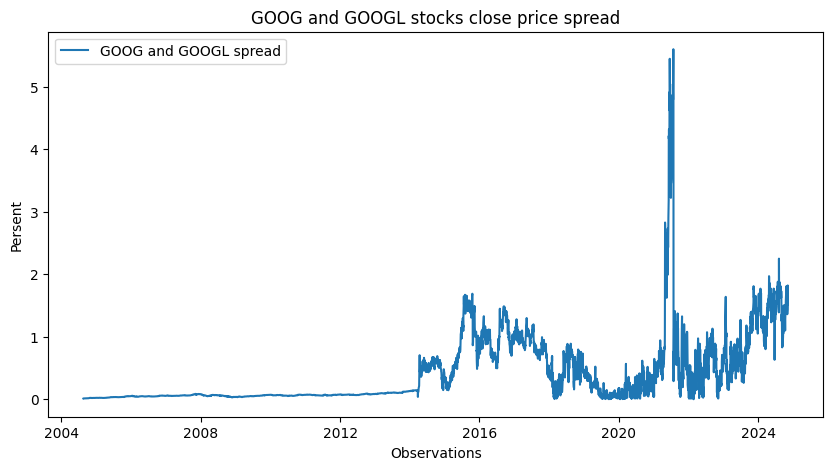

In [ ]:
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(spread.index, spread.values, label='GOOG and GOOGL spread')
plt.title('GOOG and GOOGL stocks close price spread')
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

In [ ]:
sample = spread.values
sample_dates = spread.index

In [ ]:
MODEL = 'CEV'

# get params
shoji_ozaki_p = get_parameters(model_name=MODEL, method='shoji_ozaki')
kessler_p = get_parameters(model_name=MODEL, method='kessler')
euler_p = get_parameters(model_name=MODEL, method='euler')

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169815.60746168948
`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 430, CG iterations: 303, optimality: 2.19e+00, constraint violation: 0.00e+00, execution time: 0.35 s.
Final Params: [1.43652383 1.279027   2.32044691 0.46668265]
Final Likelihood: 6361.373761809025
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169815.60746168948
`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 430, CG iterations: 303, optimality: 2.19e+00, constraint violation: 0.00e+00, execution time: 0.32 s.
Final Params: [1.43652383 1.279027   2.32044691 0.46668265]
Final Likelihood: 6361.373761809025
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169814.4956433591
`xtol` termination condition is satisfied.
Number of iterations: 126, function evaluations: 655, CG iterations: 461, optimality: 2.57e+01, constraint violation: 0.00e+00, execution 

/Users/hubievkasym/Desktop/Python Projects/SberProject/venv/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 77, function evaluations: 395, CG iterations: 238, optimality: 7.55e-05, constraint violation: 0.00e+00, execution time: 0.26 s.
Final Params: [4.29050151 0.48913611 2.32119813 0.461098  ]
Final Likelihood: 6366.860183079327
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169815.11988837025
`xtol` termination condition is satisfied.
Number of iterations: 77, function evaluations: 395, CG iterations: 238, optimality: 7.55e-05, constraint violation: 0.00e+00, execution time: 0.25 s.
Final Params: [4.29050151 0.48913611 2.32119813 0.461098  ]
Final Likelihood: 6366.860183079327


/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_41374/1721718896.py:13: RuntimeWarning: invalid value encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW


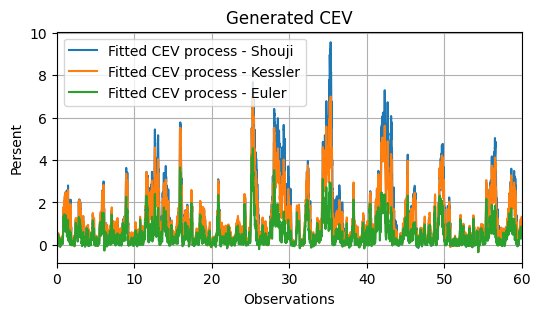

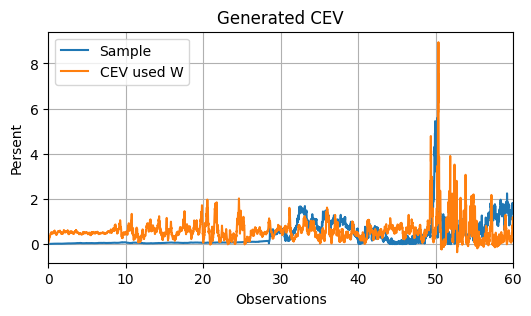

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = np.nan_to_num(cev_s[i-1] + processes[MODEL](cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW), cev_s[i-1])
    cev_k[i] = np.nan_to_num(cev_k[i-1] + processes[MODEL](cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW), cev_k[i-1])
    cev_e[i] = np.nan_to_num(cev_e[i-1] + processes[MODEL](cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW), cev_e[i-1])
    ecev[i] = np.nan_to_num(ecev[i-1] + processes[MODEL](ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1]), ecev[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s , label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, cev_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, cev_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [ ]:
MODEL = 'CKLS'

# get params
shoji_ozaki_p = get_parameters(model_name=MODEL, method='shoji_ozaki')
kessler_p = get_parameters(model_name=MODEL, method='kessler')
euler_p = get_parameters(model_name=MODEL, method='euler')

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169801.5894450969
`xtol` termination condition is satisfied.
Number of iterations: 161, function evaluations: 840, CG iterations: 520, optimality: 3.74e-01, constraint violation: 0.00e+00, execution time: 0.62 s.
Final Params: [1.71285247 0.07030896 2.32076201 0.45972292]
Final Likelihood: 6355.078801547788
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169801.5894450969
`xtol` termination condition is satisfied.
Number of iterations: 161, function evaluations: 840, CG iterations: 520, optimality: 3.74e-01, constraint violation: 0.00e+00, execution time:  0.6 s.
Final Params: [1.71285247 0.07030896 2.32076201 0.45972292]
Final Likelihood: 6355.078801547788
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169799.98728127845
`xtol` termination condition is satisfied.
Number of iterations: 139, function evaluations: 705, CG iterations: 506, optimality: 1.31e+02, constraint violation: 0.00e+00, execution

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_41374/2973448014.py:2: RuntimeWarning: invalid value encountered in scalar power
  return (theta1 + theta2 * dx) * dt + theta3 * pow(dx, theta4) * dw


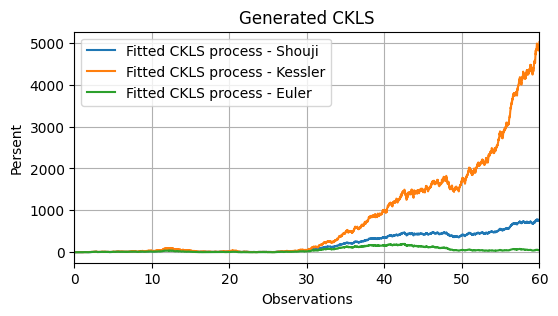

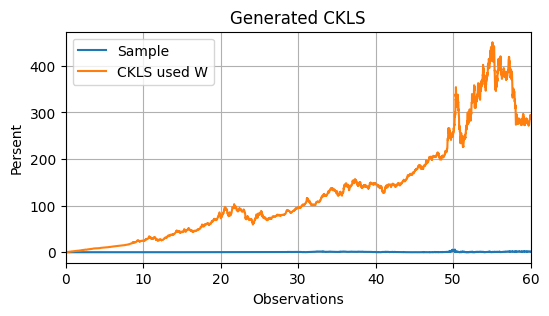

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ckls_s, ckls_k, ckls_e = np.zeros(N), np.zeros(N), np.zeros(N)
ckls_s[0], ckls_k[0], ckls_e[0] = S0, S0, S0
eckls = np.zeros(N)
eckls[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ckls_s[i] = np.nan_to_num(ckls_s[i-1] + processes[MODEL](ckls_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW), ckls_s[i-1])
    ckls_k[i] = np.nan_to_num(ckls_k[i-1] + processes[MODEL](ckls_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW), ckls_k[i-1])
    ckls_e[i] = np.nan_to_num(ckls_e[i-1] + processes[MODEL](ckls_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW), ckls_e[i-1])
    eckls[i] = np.nan_to_num(eckls[i-1] + processes[MODEL](eckls[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1]), eckls[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, ckls_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, ckls_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, ckls_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eckls, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [ ]:
MODEL = 'OU'

# get params
shoji_ozaki_p = get_parameters(model_name=MODEL, method='shoji_ozaki')
kessler_p = get_parameters(model_name=MODEL, method='kessler')
euler_p = get_parameters(model_name=MODEL, method='euler')

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -47056.31052953926


/Users/hubievkasym/Desktop/Python Projects/SberProject/venv/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 292, CG iterations: 167, optimality: 3.92e-01, constraint violation: 0.00e+00, execution time: 0.22 s.
Final Params: [1.33995861 0.47798625 1.62220423]
Final Likelihood: 4331.96624916519
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -47056.31052953926
`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 292, CG iterations: 167, optimality: 3.92e-01, constraint violation: 0.00e+00, execution time: 0.22 s.
Final Params: [1.33995861 0.47798625 1.62220423]
Final Likelihood: 4331.96624916519
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -47055.13536791726
`xtol` termination condition is satisfied.
Number of iterations: 47, function evaluations: 192, CG iterations: 107, optimality: 1.85e-04, constraint violation: 0.00e+00, execution time: 0.16 s.
Final Params: [2.76297427 0.51387056 1.61693428]
Final Likelihood: 4334.236910582199
Initial Params: [0.

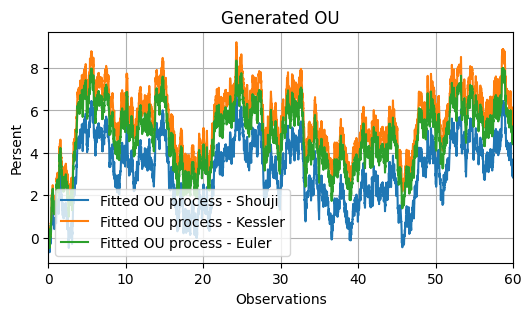

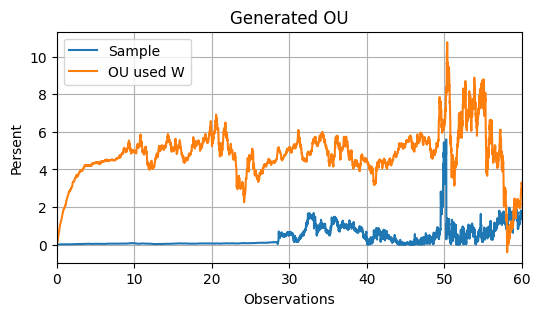

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma = kessler_p
gamma = 0.0
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ou_s, ou_k, ou_e = np.zeros(N), np.zeros(N), np.zeros(N)
ou_s[0], ou_k[0], ou_e[0] = S0, S0, S0
eou = np.zeros(N)
eou[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ou_s[i] = ou_s[i-1] + processes[MODEL](ou_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], gamma, dt, dW)
    ou_k[i] = ou_k[i-1] + processes[MODEL](ou_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], gamma, dt, dW)
    ou_e[i] = ou_e[i-1] + processes[MODEL](ou_e[i-1], euler_p[0], euler_p[1], euler_p[2], gamma, dt, dW)
    eou[i] = eou[i-1] + processes[MODEL](eou[i-1], euler_p[0], euler_p[1], euler_p[2], gamma, dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, ou_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, ou_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, ou_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eou, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [ ]:
MODEL = 'CIR'

# get params
shoji_ozaki_p = get_parameters(model_name=MODEL, method='shoji_ozaki')
kessler_p = get_parameters(model_name=MODEL, method='kessler')
euler_p = get_parameters(model_name=MODEL, method='euler')

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -66991.2297525083
`xtol` termination condition is satisfied.
Number of iterations: 46, function evaluations: 212, CG iterations: 96, optimality: 1.43e-01, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [0.9768597  1.56949417 1.99994787]
Final Likelihood: 6178.007658352915
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -66991.2297525083
`xtol` termination condition is satisfied.
Number of iterations: 46, function evaluations: 212, CG iterations: 96, optimality: 1.43e-01, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [0.9768597  1.56949417 1.99994787]
Final Likelihood: 6178.007658352915
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -66970.3729464788
`xtol` termination condition is satisfied.
Number of iterations: 158, function evaluations: 708, CG iterations: 370, optimality: 2.36e-02, constraint violation: 0.00e+00, execution time: 0.61 s.
Final Params: [0.25596539 2.31003

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_41374/3007526269.py:2: RuntimeWarning: invalid value encountered in scalar power
  return (theta1 - theta2 * dx) * dt + theta3 * dx ** 0.5 * dw


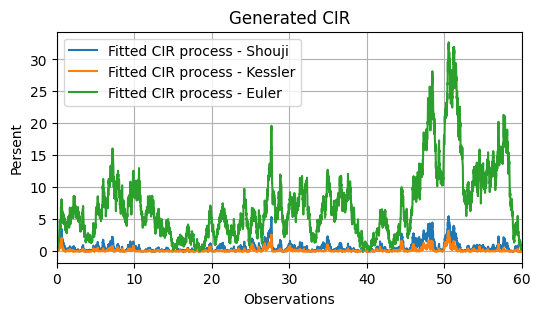

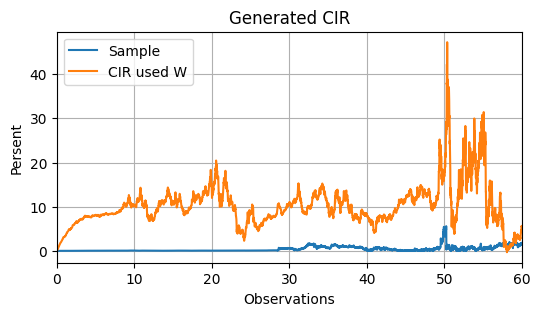

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma = kessler_p
gamma = 0.0
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cir_s, cir_k, cir_e = np.zeros(N), np.zeros(N), np.zeros(N)
cir_s[0], cir_k[0], cir_e[0] = S0, S0, S0
ecir = np.zeros(N)
ecir[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cir_s[i] = np.nan_to_num(cir_s[i-1] + processes[MODEL](cir_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], gamma, dt, dW), cir_s[i-1])
    cir_k[i] = np.nan_to_num(cir_k[i-1] + processes[MODEL](cir_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], gamma, dt, dW), cir_k[i-1])
    cir_e[i] = np.nan_to_num(cir_e[i-1] + processes[MODEL](cir_e[i-1], euler_p[0], euler_p[1], euler_p[2], gamma, dt, dW), cir_e[i-1])
    ecir[i] = np.nan_to_num(ecir[i-1] + processes[MODEL](ecir[i-1], euler_p[0], euler_p[1], euler_p[2], gamma, dt, cW[i-1]), ecir[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cir_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, cir_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, cir_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecir, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [ ]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est_bic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    euler_est_aic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    euler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    ozaki_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    ozaki_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    ozaki_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    shoji_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    shoji_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    shoji_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    kessler_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    kessler_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    kessler_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    exact_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    exact_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    exact_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -47055.403279490485
`xtol` termination condition is satisfied.
Number of iterations: 40, function evaluations: 93, CG iterations: 62, optimality: 3.12e-06, constraint violation: 0.00e+00, execution time:  0.1 s.
Final Params: [0.30179785 1.6197296 ]
Final Likelihood: 4326.2228723518865
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169815.11988837025
`xtol` termination condition is satisfied.
Number of iterations: 77, function evaluations: 395, CG iterations: 238, optimality: 7.55e-05, constraint violation: 0.00e+00, execution time: 0.25 s.
Final Params: [4.29050151 0.48913611 2.32119813 0.461098  ]
Final Likelihood: 6366.860183079327
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -66989.98247236079
`xtol` termination condition is satisfied.
Number of iterations: 60, function evaluations: 204, CG iterations: 110, optimality: 1.39e-05, constraint violation: 0.00e+00, execution time: 0.16 s.
Final Params: [3.85429794 0.

/Users/hubievkasym/Desktop/Python Projects/SberProject/venv/lib/python3.9/site-packages/pymle/core/TransitionDensity.py:114: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time: 0.26 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169815.54246571407
`xtol` termination condition is satisfied.
Number of iterations: 95, function evaluations: 435, CG iterations: 299, optimality: 2.11e-05, constraint violation: 0.00e+00, execution time: 0.37 s.
Final Params: [6.9152072  0.37316796 2.65188047 0.58470651]
Final Likelihood: 6558.219338124478
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -66991.17559956513
`xtol` termination condition is satisfied.
Number of iterations: 58, function evaluations: 232, CG iterations: 103, optimality: 9.71e-05, constraint violation: 0.00e+00, execution time: 0.19 s.
Final Params: [3.54697715 0.60214961 1.99999974]
Final Likelihood: 6429.622448148304
Initial Params: [0.01, 0.2]
I

100%|██████████| 1/1 [00:26<00:00, 26.10s/it]

`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 355, CG iterations: 207, optimality: 2.02e-05, constraint violation: 0.00e+00, execution time: 0.25 s.
Final Params: [1.71383573 0.0100012  2.32082853 0.45971191]
Final Likelihood: 6355.402817794153


In [ ]:
best_ind = argmin(euler_est_aic)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est_aic[0], models[0], euler_params[0],\
     euler_est_aic[1], models[1], euler_params[1],\
     euler_est_aic[2], models[2], euler_params[2],\
     euler_est_aic[3], models[3], euler_params[3],\
     euler_est_aic[4], models[4], euler_params[4],\
     euler_est_aic[5], models[5], euler_params[5],\
     euler_est_aic[6], models[6], euler_params[6]))

print("The best model is {} \
    with param {}".format(models[best_ind], euler_params[best_ind]))

AIC values for Euler estimation:
       -8648.446 - BM model with params [0.30179785 1.6197296 ],
       -12725.720 - CEV model with params [4.29050151 0.48913611 2.32119813 0.461098  ],
       -12370.847 - CIR model with params [3.85429794 0.45267217 1.99999999],
       -1666.333 - GBM model with params [0.97872265 2.        ],
       -1683.800 - IGBM model with params [0.8918393 0.2091893 2.       ],
       -8661.368 - OU model with params [2.44559925 0.53776683 1.61735702],
       -12702.806 - CKLS model with params [1.71383573 0.0100012  2.32082853 0.45971191],
       
The best model is CEV     with param [4.29050151 0.48913611 2.32119813 0.461098  ]


In [ ]:
best_ind = argmin(euler_est_bic)
print("BIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est_bic[0], models[0], euler_params[0],\
     euler_est_bic[1], models[1], euler_params[1],\
     euler_est_bic[2], models[2], euler_params[2],\
     euler_est_bic[3], models[3], euler_params[3],\
     euler_est_bic[4], models[4], euler_params[4],\
     euler_est_bic[5], models[5], euler_params[5],\
     euler_est_bic[6], models[6], euler_params[6]))

print("The best model is {} \
    with param {}".format(models[best_ind], euler_params[best_ind]))

NameError: name 'euler_est_bic' is not defined